<a href="https://colab.research.google.com/github/therealbct/dates/blob/main/MEXC_API_RW_style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--------------------------------------------------------------------------
# MEXC perp historical data API

--------------------------------------------------------------------------

Loading up standard rw libs

All key functions in this notebook (different APIs/end points):
- Fetch or Index per KLines
  - **get_single_mexc_market**
  - **get_multiple_mexc_markets**
- Fetch FR
  - **get_single_mexc_funding_rate**
  - **get_multiple_mexc_funding_rate**
- Fetch spot KLines
  - **get_single_mexc_spot_market**
  - **get_multiple_mexc_spot_markets**

Other functions used for analysis
- plot_FR_pred
  - purpose: uncover an "exploit" (alpha) due to the way MEXC's FR is calculated
  - plot distribution of predictor/independent variable (MEXC's recent past FR, FTX's) conditionnally split on 3 outcomes: MEXC's FR is high/med/low (ranges based off the "sticky" spots on MEXC - see mexc_hlines function)


In [ ]:
# :::::::: MUST EXECUTE: MOVE TO LIB ::::::::

# snippet: rw load rwrtools v0.4

# lists of libraries: rwRtools dependencies (install but don't load) and libs_to_load (install and load)
dependencies <- c(
  "pacman", "ttr", "googleauthr", "doparallel", "googlecloudstorager", 
  "iterators", "R.methodsS3", "openssl", "foreach", "xts", "R.oo", "feather", 
  "R.utils"
)
libs_to_load <- c("tidyverse", "lubridate", "purrr", "stringr", "zoo", "glue", "here", "roll")

# comment out next two lines if not loading rsims
rsims_dependencies <- c("stringr", "lubridate", "roll", "Rcpp")
dependencies <- c(dependencies, rsims_dependencies)

# capitalisation of call to CRAN may not always match capitalisation of package name (eg library(doParallel) vs sudo apt install r-cran-doparallel).
install_from_cran <- gsub("^(?!R\\.)([\\w]+)", "\\L\\1", unique(c(libs_to_load, dependencies)), perl = TRUE)  # convert to lowercase all letters other than an "R" at the start followed by "."

msg1 <- system2('sudo', args = c('apt-get', 'update'),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

msg2 <- system2(
  'sudo', 
  args = c('apt', 'install', sub('', 'r-cran-', install_from_cran, '-y --fix-missing')),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

pacman::p_load(char = libs_to_load, install = FALSE)

# install and load rwRtools from GH (sans dependencies)
pacman::p_load_current_gh("RWLab/rwRtools", dependencies = FALSE)

# install and load rsims from GH (sans dependencies)
# pacman::p_load_current_gh("Robot-Wealth/rsims", dependencies = FALSE)

# output messages from install - optional, for debugging
# msg

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))


* checking for file ‘/tmp/RtmpnLoFSu/remotes3d3972d825/RWLab-rwRtools-985e440/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.17.tar.gz’



In [ ]:
# :::::::: MUST EXECUTE: MOVE TO LIB ::::::::

# to display progress in colab while loop is going
library(IRdisplay)
print_ <- function(t) display_text(t)
cat_ <- function(t) display_text(t)

In [ ]:
# :::::::: MUST EXECUTE: MOVE TO LIB ::::::::
mexc_api <- function(mrkt_url, params=list()) {
  mexc_base_url <- 'https://contract.mexc.com'
  url <- paste(mexc_base_url, mrkt_url, sep="/")
  response <- httr::GET(url, query=params)
  res = httr::content(response,  as = "parsed")
  return (res)
}

mexc_ping <- function() {
  mrkt_url <- 'api/v1/contract/ping'
  mexc_api(mrkt_url) %>%
    as_tibble() %>%
    rename(date = data) %>%
    mutate(date = as_datetime(date/1000, tz="UTC"))
}

mexc_ping()

success code date               
1 TRUE    0    2022-08-07 12:19:29

--------------------------------------------------------------------------
# A. MEXC Market & Index K Lines

In [ ]:
# :::::::: MUST EXECUTE: MOVE TO LIB ::::::::

#'-----------------------------------------------------------------------------
#' Helper function: Convert resolution in seconds to MEXC's standard strings
#' 
#' Purpose: map to RW functions arguments in seconds
mexc_map_resolution <- function(res) {
  a <- str_split("Min1、Min5、Min15、Min30、Min60、Hour4、Hour8、Day1、Week1、Month1", "、")[[1]]
  names(a) <- c(60*1, 60*5, 60*15, 60*30, 60*60, 60*60*4, 60*60*8, 60*60*24, 60*60*24*7, 60*60*24*21)
  a
  return(a[as.character(res)][[1]])
}

#'-----------------------------------------------------------------------------
#' Get Single MEXC Futures Market & index v0.1
#' 
#' @description Get market data for a single MEXC futures market.
#'
#' @param market name of the Futures market (string)
#' @param resolution representing aggregation length in seconds (int)
#' options available:
#'    60      300      900     1800     3600    14400    28800    86400 
#'    "Min1"   "Min5"  "Min15"  "Min30"  "Min60"  "Hour4"  "Hour8"   "Day1" 
#'    604800  1814400 
#'    "Week1" "Month1" 
#' @param start_time human readable start time in UTC (string)
#' @param end_time human readable end time in UTC (string)
#' @param get_index TRUE: get index KLine / FALSE: get perp KLine
#'
#' @return dataframe of prices if API call was successful, otherwise call result
#' @export
#'
#' @examples
#' get_single_mexc_market("BTC_USDT", resolution = 86400, start_time = "2019-07-20", end_time = "2022-06-30)
get_single_mexc_market <- function(sym="BTC_USDT", 
                                   resolution=86400, 
                                   start_time = "2019-01-01", 
                                   end_time = "",
                                   get_index = FALSE) {
  interval <- resolution
  if(get_index) {
    mrkt_url <- 'api/v1/contract/kline/index_price'    
  } else {
    mrkt_url <- 'api/v1/contract/kline'
  }
  url <- paste(mrkt_url, sym, sep="/")
  start_time <- as.numeric(as.POSIXct(start_time, tz = "UTC"))
  if(end_time == "") {
    end_time <-  ""
  } else {
    end_time <- as.numeric(as.POSIXct(end_time, tz = "UTC"))
  }
  interval <- mexc_map_resolution(interval)
  
  res_json <- mexc_api(url, list(interval=interval,
                                 start=start_time,
                                 end=end_time))
  if(res_json$success == TRUE && length(res_json$data[[1]]) > 0) {
#    print_(length(res_json$data[[1]]))
    ohlcv <- res_json$data %>%
      purrr::transpose() %>%
      map_df(as.data.frame, .name_repair = "universal") %>%
      as_tibble() %>%
      dplyr::rename(volume = vol) %>%
      dplyr::mutate(date = lubridate::as_datetime(time)) %>%
      dplyr::select(-time, -amount, -realOpen, 
                    -realHigh, -realLow, -realClose) %>%
      arrange(date) # it appears already comes sorted, but to ensure.
    
    return(ohlcv)
  } else if(length(res_json$data[[1]]) == 0) {
    print_("Empty table.")
    
    return(res_json$data %>% as.data.frame)
  } else {
    print_("Request failed.")
    
    return(res_json)
  }

}

#'-----------------------------------------------------------------------------
#' Get Multiple Markets & Index v0.11 - FTX, MEXC; TBD: Coinex, KuCoin
#' 
#' @description Get market data for multiple markets.
#'
#' @param market name of the markets (vector of string)
#' @param resolution representing aggregation length in seconds (int)
#' @param start_time human readable start time in UTC (string)
#' @param end_time human readable end time in UTC (string)
#' @param get_index TRUE: get index KLines / FALSE: get perp KLines
#'
#' @return dataframe of prices if API call was successful, otherwise call result
#' @export
#'
#' @examples
#' get_multiple_ftx_markets(c("BTC-PERP", "ETH-PERP"), resolution = 86400, start_time = "2019-07-20", end_time = "2022-06-30)
get_multiple_mexc_markets <- function(markets, 
                                      resolution = 86400, 
                                      start_time = "2019-07-20", 
                                      end_time = "",
                                      get_index = FALSE) {
  prices <- data.frame()
  for(market in markets) {
    cat_(glue("Fetching {market}...")) # print w/o line break
    these_prices <- get_single_mexc_market(market, 
                                           resolution = resolution, 
                                           start_time = start_time, 
                                           end_time = end_time,
                                           get_index = get_index)
    if(!is.null(these_prices)) {
      print_(glue("Successful: {length(these_prices[[1]])} rows."))
      these_prices <- these_prices %>% 
        dplyr::mutate(ticker = market)
      
      prices <- dplyr::bind_rows(prices, these_prices)
    } else {
      print_(glue("Failed."))
    }
  }
    
    prices
}


In [ ]:
get_multiple_mexc_markets(c("BTC_USDT", "ETH_USDT"), resolution=60*60*24) %>%
  head()


Fetching BTC_USDT...Successful: 791 rows.
Fetching ETH_USDT...Successful: 791 rows.


open   close  high   low    volume   date       ticker  
1 9779.5 9619.5 9849.5 9605.5 12648208 2020-06-05 BTC_USDT
2 9619.5 9679.5 9735.0 9531.0 27077653 2020-06-06 BTC_USDT
3 9679.5 9741.5 9802.0 9401.0 22092848 2020-06-07 BTC_USDT
4 9741.5 9781.5 9799.0 9651.0 25817097 2020-06-08 BTC_USDT
5 9781.5 9774.0 9870.5 9608.5 44778753 2020-06-09 BTC_USDT
6 9774.0 9880.5 9986.0 9702.5 40197983 2020-06-10 BTC_USDT

In [ ]:
get_multiple_mexc_markets(c("BTC_USDT", "ETH_USDT"), 
                          resolution=60*60*24)$ticker %>%
  unique()

Fetching BTC_USDT...Successful: 791 rows.
Fetching ETH_USDT...Successful: 791 rows.


[1] "BTC_USDT" "ETH_USDT"

Fetching ETH_USDT...Successful: 791 rows.
Fetching BTC_USDT...Successful: 791 rows.
Fetching SOL_USDT...Successful: 679 rows.


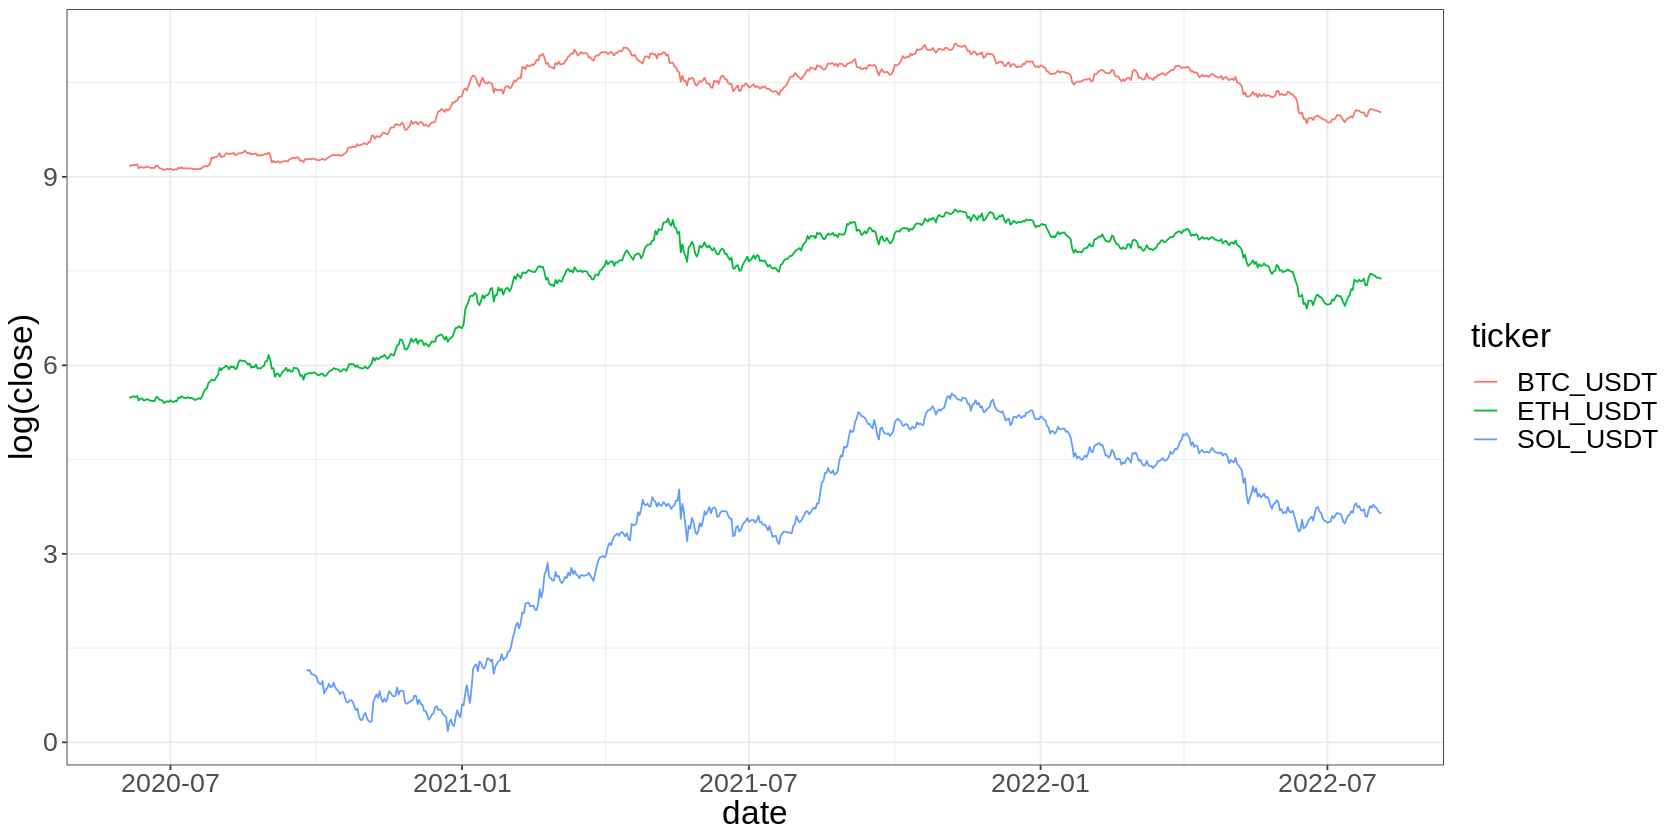

In [ ]:
# price (log of)
get_multiple_mexc_markets(c("ETH_USDT", "BTC_USDT", "SOL_USDT")) %>%
  ggplot(aes(color=ticker, x=date, y=log(close))) + geom_line()

Fetching BTC_USDT...Successful: 2001 rows.
Fetching ETH_USDT...Successful: 2001 rows.
Fetching BTC_USDT...Successful: 2001 rows.
Fetching ETH_USDT...Successful: 2001 rows.


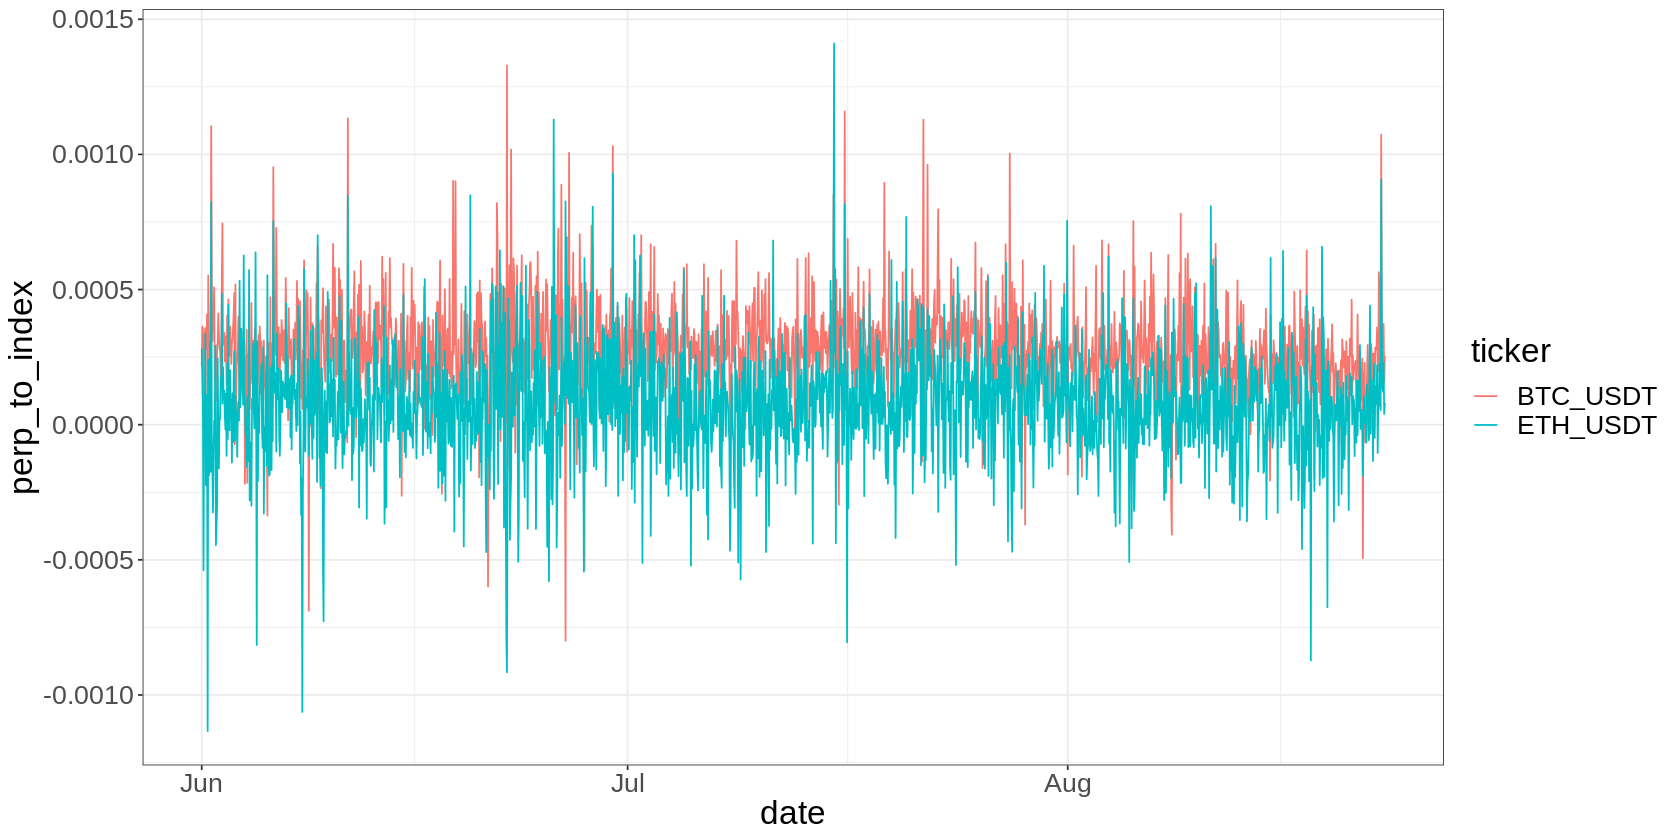

In [ ]:
# Perp - to - index prices

markets <- get_multiple_mexc_markets(c("BTC_USDT", "ETH_USDT"), resolution=60*60, start_time="2021-06-01", get_index=FALSE)
indices <- get_multiple_mexc_markets(c("BTC_USDT", "ETH_USDT"), resolution=60*60, start_time="2021-06-01", get_index=TRUE)

left_join(markets, indices, by = c("ticker" = "ticker", "date" = "date")) %>%
  select(c(ticker, date, close.x, close.y)) %>%
  mutate(perp_to_index = close.x/close.y -1) %>%
  # tidyr::gather(key=market.x_or_indice.y, close, -c(ticker, date)) %>%
  # mutate(tick_type = glue("{ticker}-{market.x_or_indice.y}")) %>%
  ggplot(aes(x=date, y=perp_to_index, color=ticker)) + geom_line()


Fetching ETH_USDT...Successful: 791 rows.
Fetching BTC_USDT...Successful: 791 rows.
Fetching SOL_USDT...Successful: 679 rows.


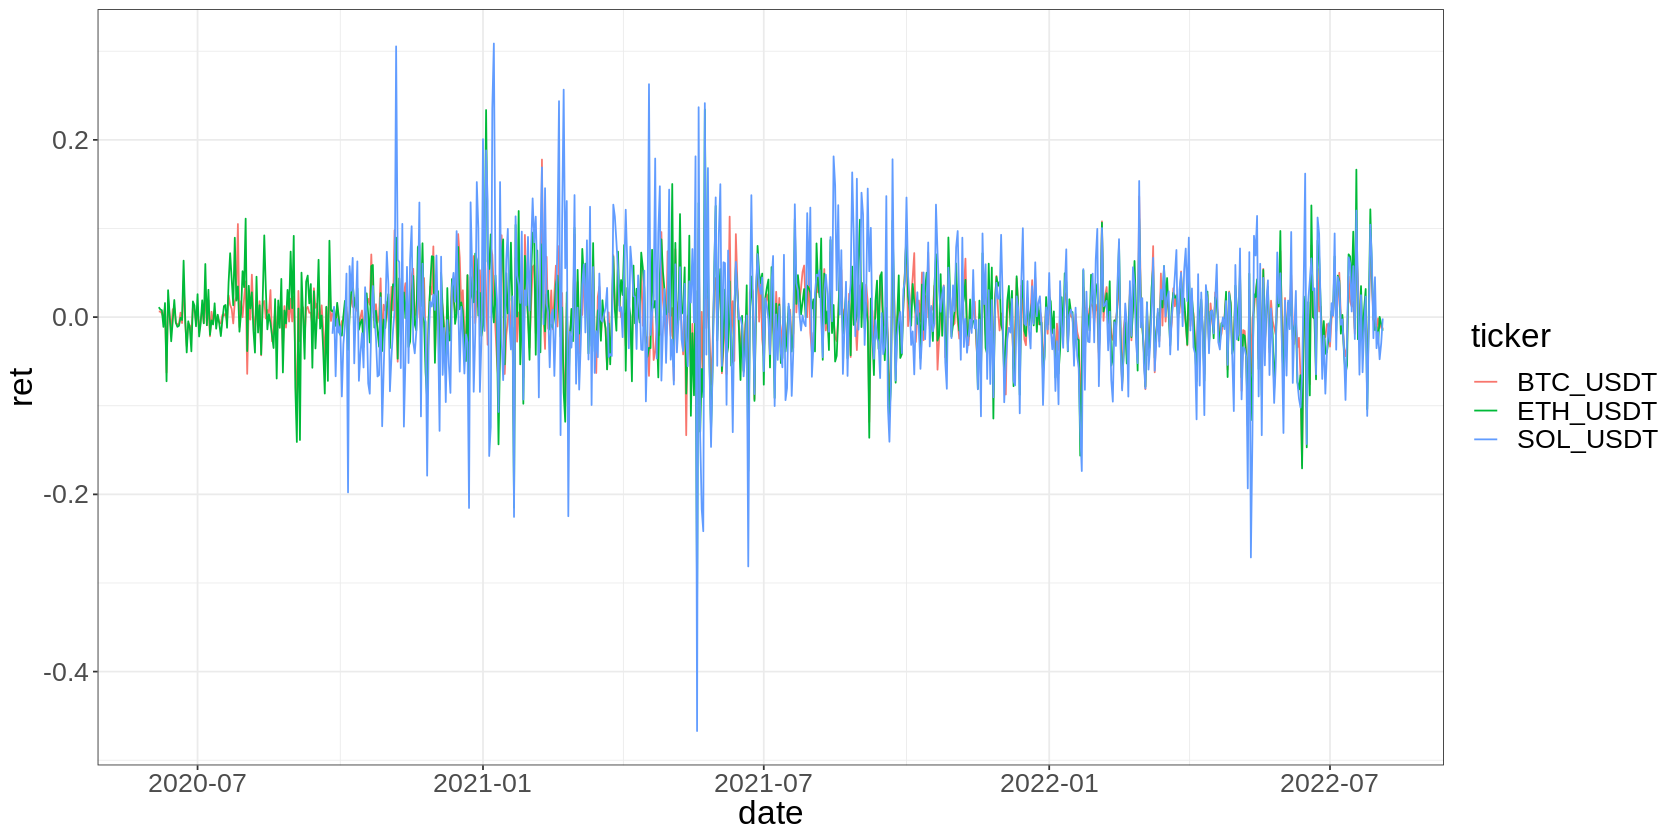

In [ ]:
# Returns

get_multiple_mexc_markets(c("ETH_USDT", "BTC_USDT", "SOL_USDT")) %>%
  mutate(ret = log(close)-log(lag(close))) %>%
  filter(ret < 1) %>% filter(ret > -1) %>%
  drop_na() %>%
  ggplot(aes(color=ticker, x=date, y=ret)) + geom_line()

--------------------------------------------------------------------------
# B. MEXC Funding Rates

In [ ]:
# :::::::: MUST EXECUTE: MOVE TO LIB ::::::::

# functions to retrive MEXC's perp funding rates

#'-----------------------------------------------------------------------------
# Helper function: collect a single "page" of funding rate data for a single symbol
# NOTE1: funding rate page 0 is the same as 1... count starts at 1!
# NOTE2: NOT SORTED - API appears to go reverse chron (top new, bottom old)
get_single_mexc_funding_rate_page <- function(sym="BTC_USDT", page=1, verbose=TRUE) {
  mrkt_url <- 'api/v1/contract/funding_rate/history'
  res_json <- mexc_api(mrkt_url, list(symbol=sym, 
                                      page_num=page, 
                                      page_size=100))
  if(res_json$success == FALSE) {
    if(verbose) print_("Request failed.")
    return(res_json)
  }

  if(length(res_json$data$resultList) > 0) {
    if(verbose) print_(length(res_json$data$resultList[[1]]))
    ohlcv <- res_json$data$resultList %>%
      map_df(as.data.frame, .name_repair = "universal") %>%
      as_tibble() %>%
      dplyr::rename(date = settleTime,
                    rate = fundingRate,
                    ticker = symbol) %>%    # standard RW schema
      dplyr::mutate(date = lubridate::as_datetime(date / 1000)) %>%
      arrange(date)   # API sends in reverse chron
    return(ohlcv)
  } else {
    if(verbose) print_("Empty table.")
    return(res_json$data$resultList)
  }
}

#'-----------------------------------------------------------------------------
#' Get Single MEXC Futures Market Funding Rate v0.1
#' 
#' @description Get market data for a single MEXC futures market.
#'
#' @param market name of the Futures market (string)
#'
#' @return dataframe of funding rates if API call was successful, otherwise call result
#' @export
#'
#' @examples
#' get_single_mexc_funding_rate("BTC_USDT")
get_single_mexc_funding_rate <- function(sym="BTC_USDT") {
  FR = data.frame()
  for(page in 1:10) {
    FR_page <- get_single_mexc_funding_rate_page(sym, page, verbose=FALSE)
    if(length(FR_page)==0) break 
    FR <- dplyr::bind_rows(FR_page, FR) %>%   # we're going back in time - assuming asc dates
      arrange(date)                           # ensure asc
  }
  return(FR)
}

#'-----------------------------------------------------------------------------
#' Get Multiple MEXC Futures Market Funding Rate time series v0.1
#' 
#' @description Get market data for a multiple MEXC futures market.
#'
#' @param market names of the Futures markets (vector)
#'
#' @return dataframe of funding rates if API call was successful, otherwise call result
#' @export
#'
#' @examples
#' get_multiple_mexc_funding_rate(c("BTC_USDT", "ETH_USDT"))
get_multiple_mexc_funding_rate <- function(markets) {
  prices <- data.frame()
  for(market in markets) {
    cat_(glue("Fetching {market}...")) # print w/o line break
    these_prices <- get_single_mexc_funding_rate(market)
    if(!is.null(these_prices)) {
      print_(glue("Successful: {length(these_prices[[1]])} rows."))
      # these_prices <- these_prices %>% 
      #   dplyr::mutate(ticker = market)
      
      prices <- dplyr::bind_rows(prices, these_prices)
    } else {
      print_(glue("Failed."))
    }
  }
    
  prices
}

In [ ]:
MEXC_rate <- get_single_mexc_funding_rate("BTC_USDT")
MEXC_rate %>% 
  head()

ticker   rate       date               
1 BTC_USDT 0.00005000 2021-09-07 00:00:00
2 BTC_USDT 0.00005000 2021-09-07 08:00:00
3 BTC_USDT 0.00018864 2021-09-07 16:00:00
4 BTC_USDT 0.00005000 2021-09-08 00:00:00
5 BTC_USDT 0.00015000 2021-09-08 08:00:00
6 BTC_USDT 0.00015000 2021-09-08 16:00:00

Fetching ETH_USDT...Successful: 1000 rows.
Fetching BTC_USDT...Successful: 1000 rows.
Fetching SOL_USDT...Successful: 1000 rows.


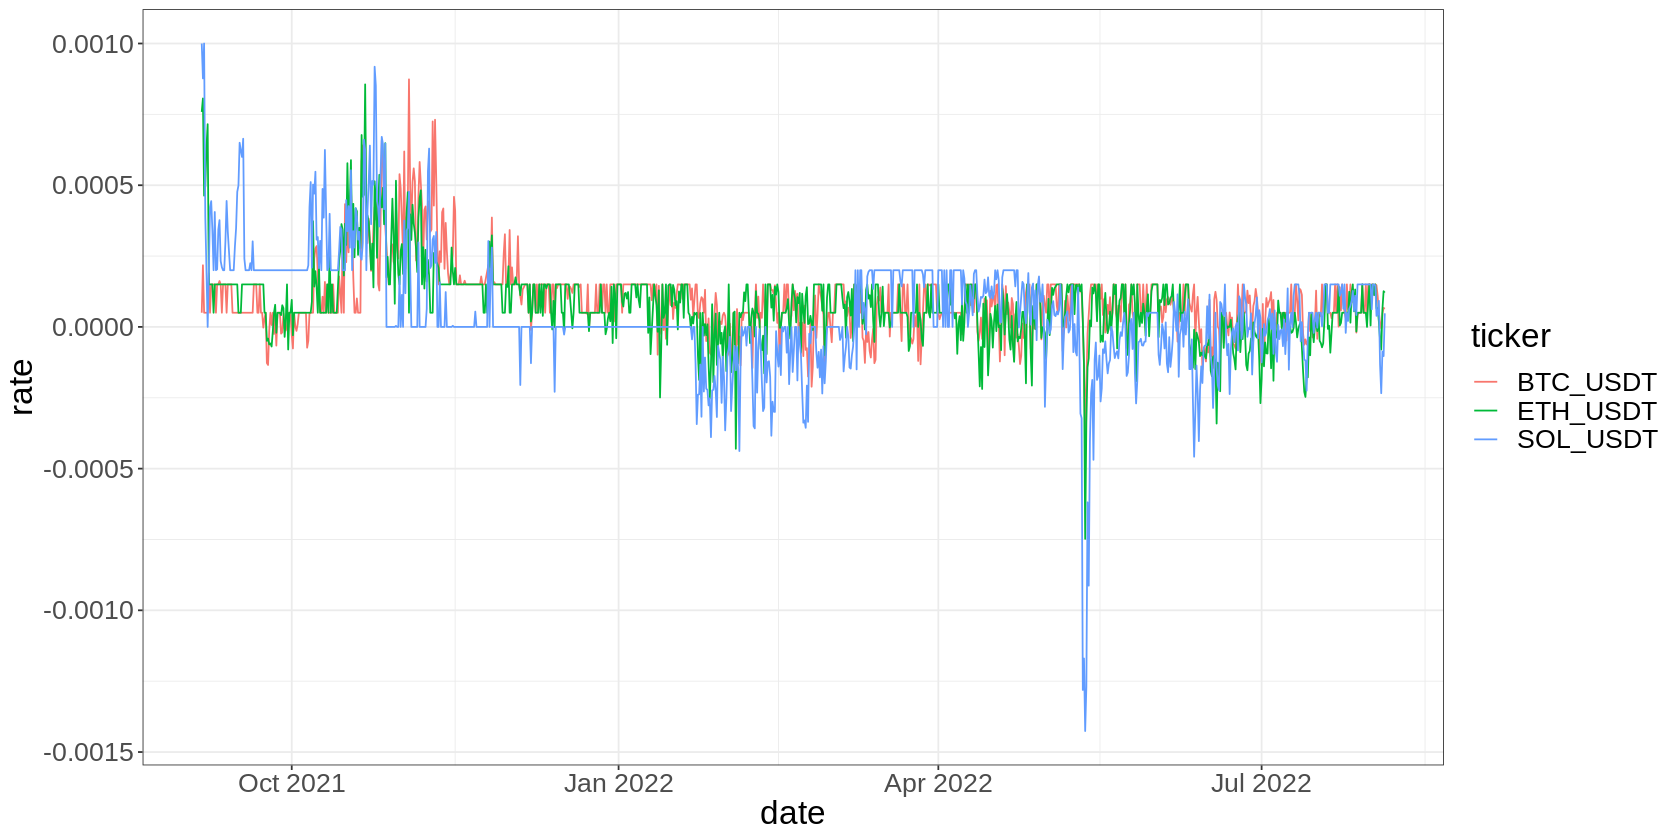

In [ ]:
get_multiple_mexc_funding_rate(c("ETH_USDT", "BTC_USDT", "SOL_USDT")) %>%
  ggplot(aes(color=ticker, x=date, y=rate)) + geom_line()

--------------------------------------------------------------------------
# C. FTX data from RW for comparison

In [ ]:
rwlab_data_auth()

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/auth?client_id=603366585132-0l5tra7gl2i20iftqangp7iskte4f3s0.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code



Enter authorization code: 4/1AdQt8qhNc19NR9JDaJPsNFan6hSTftHKlCtxP5LObNUh3NIeVSbBXFLygYE


In [ ]:
# snippet: rw crypto load ftx futures v0.1
futures <- rwRtools::crypto_get_futures()

# snippet: rw crypto load ftx perpetual funding rates v0.1
perp_rate <- rwRtools::crypto_get_perp_rates()

BTC <- futures %>% 
  filter(ticker == 'BTC-PERP') %>%
  inner_join(perp_rate, by = c('ticker','date')) %>%
  na.omit() %>%
  arrange(date) %>%
  mutate(
    price_change = log(close / lag(close)),
    funding_accrual = -lead(rate),
    funding_rate = -roll_mean(rate, 24)
  ) %>% 
  na.omit()

# BTC %>%
#   ggplot(aes(x=funding_rate, y=funding_accrual)) + 
#   geom_point() +
#   geom_smooth(method='lm')

ℹ Downloading ftx_futures_ohlc_1h.feather

✔ Saved ftx_futures_ohlc_1h.feather to ftx/ftx_futures_ohlc_1h.feather  ( 196.1…





File successfully transferred


ℹ Downloading ftx_perpetual_funding_rates.feather

✔ Saved ftx_perpetual_funding_rates.feather to ftx/ftx_perpetual_funding_rates.…





File successfully transferred


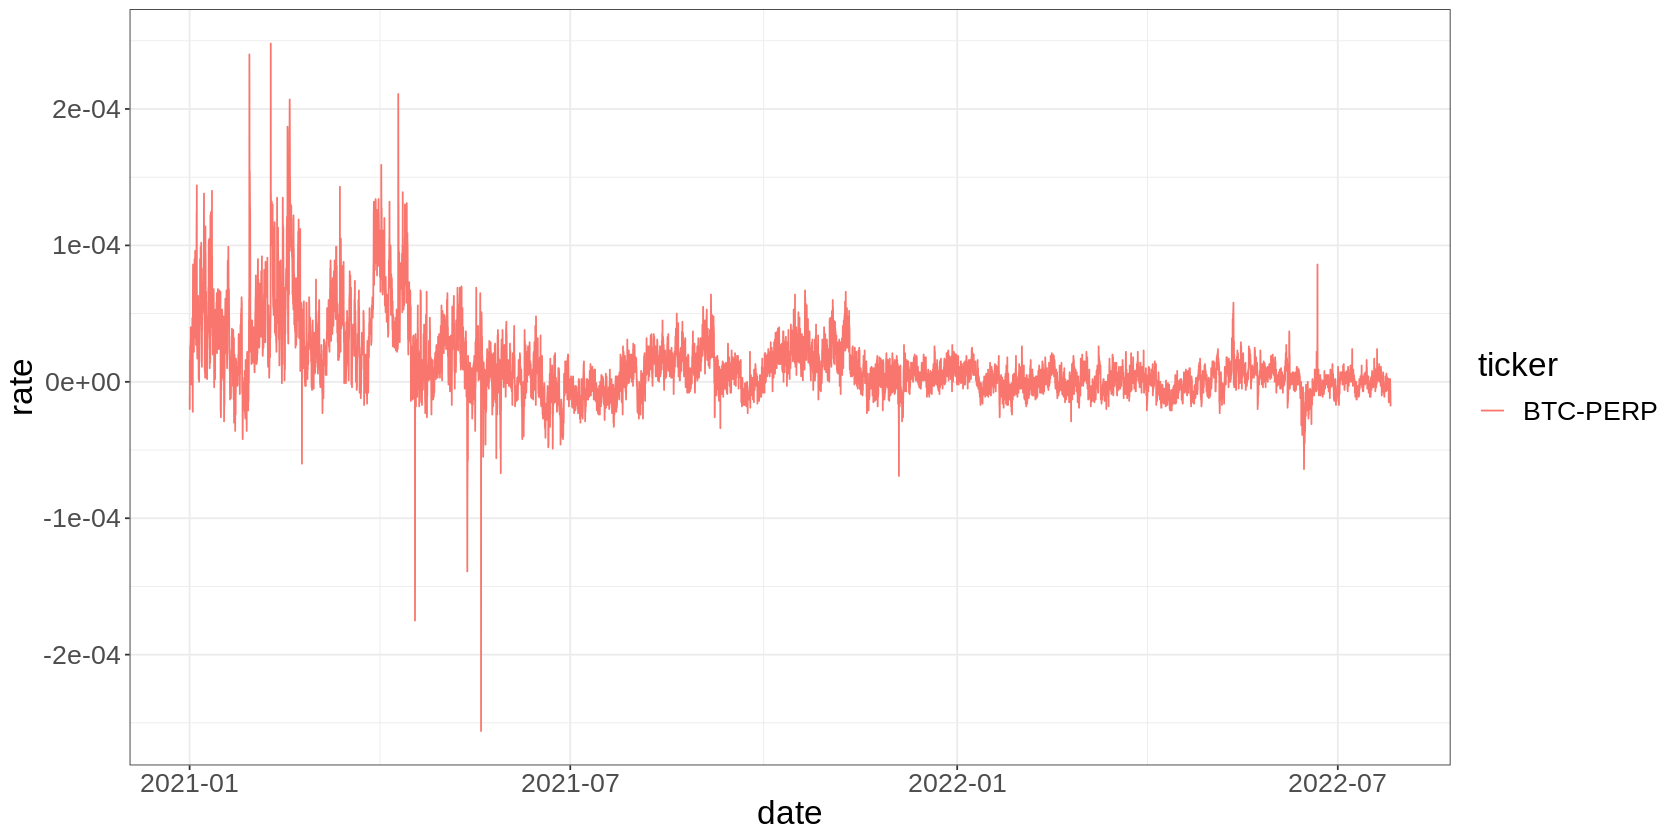

In [ ]:
FTX_rate <- perp_rate %>% 
  filter(ticker == "BTC-PERP") %>%
  filter(date>=as.Date("2021-01-01")) %>%
  mutate(date = lubridate::as_datetime(date))

FTX_rate %>%
  ggplot(aes(color=ticker, x=date, y=rate)) + geom_line()

In [ ]:
FTX_rate$date[[1]]+60*60

[1] "2021-01-01 01:00:00 UTC"

Group FTX by contiguous buckets of 8h aligned on UTC 0, 8, 16 (to join with MEXC)

In [ ]:
FTX_rate_8h <- FTX_rate %>%
  group_by(.D1 = date(date-60*60),  # remove 1h from the timestamp so as to include 00:00 to the previous day
           .H8 = as.integer(hour(date-60*60)/8)) %>%
  summarize(ticker = last(ticker), 
            date = last(na.omit(date)), 
            rate = sum(rate), 
            .groups = 'drop') %>%   # to eliminate error message (?)
  ungroup() %>%
  arrange(ticker, date) %>%         # to ensure groupby doesnt re-order differently (should not give D1 before H8)
  select(-.H8, -.D1)

FTX_rate_8h %>% head()


### MEXC vs. FTX (8h trailing sum) Funding Rates

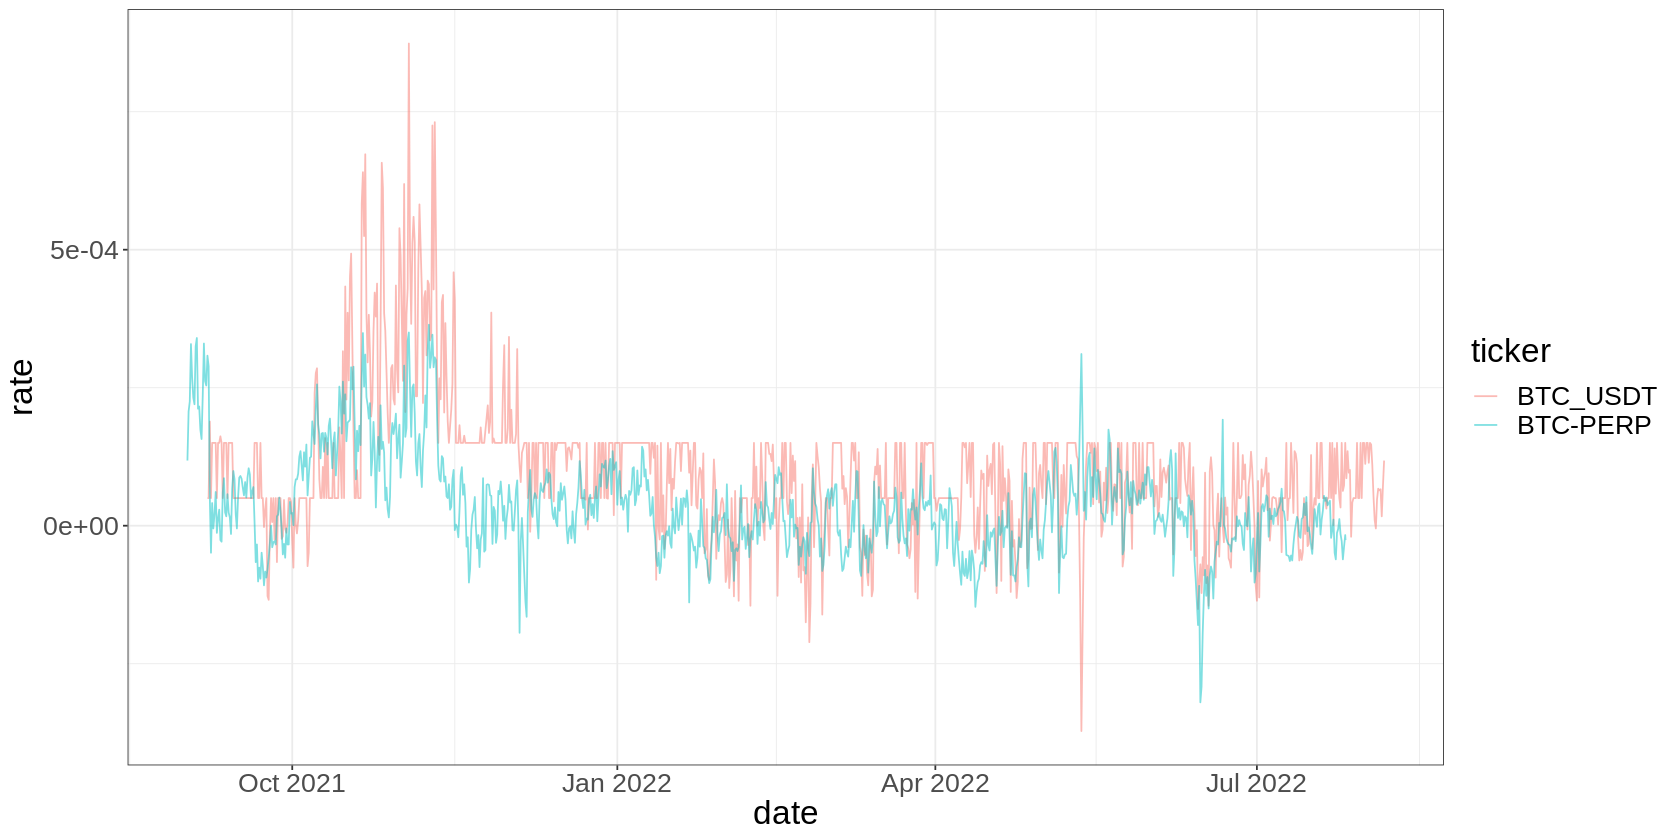

In [ ]:
MEXC_rate %>%
  merge(FTX_rate_8h, all=TRUE) %>% # FTX payments every hour vs. every 8h for MEXC
  filter(date > as.Date("2021-09-01")) %>%
  ggplot(aes(color=ticker, x=date, y=rate)) + geom_line(alpha=.5)#, labels = c("BTC Perp FR MEXC", "BTC Perp FR FTX (10x for scale)"))

24% of the MEXC funding rates are capped in 2022

In [ ]:
tmp <- MEXC_rate %>% 
  filter(date > as.Date("2022-01-01")) %>%
  select(rate)
  
sum(tmp$rate == 0.00015, na.rm=TRUE) /length(tmp[[1]])
  # sum(is_max)

[1] 0.2419106

Correlation analysis

date                MEXC_BTC_FR FTX_BTC_FR
1 2021-09-07 00:00:00 0.00005000   0.000308 
2 2021-09-07 08:00:00 0.00005000   0.000289 
3 2021-09-07 16:00:00 0.00018864   0.000053 
4 2021-09-08 00:00:00 0.00005000  -0.000049 
5 2021-09-08 08:00:00 0.00015000   0.000041 
6 2021-09-08 16:00:00 0.00015000  -0.000005

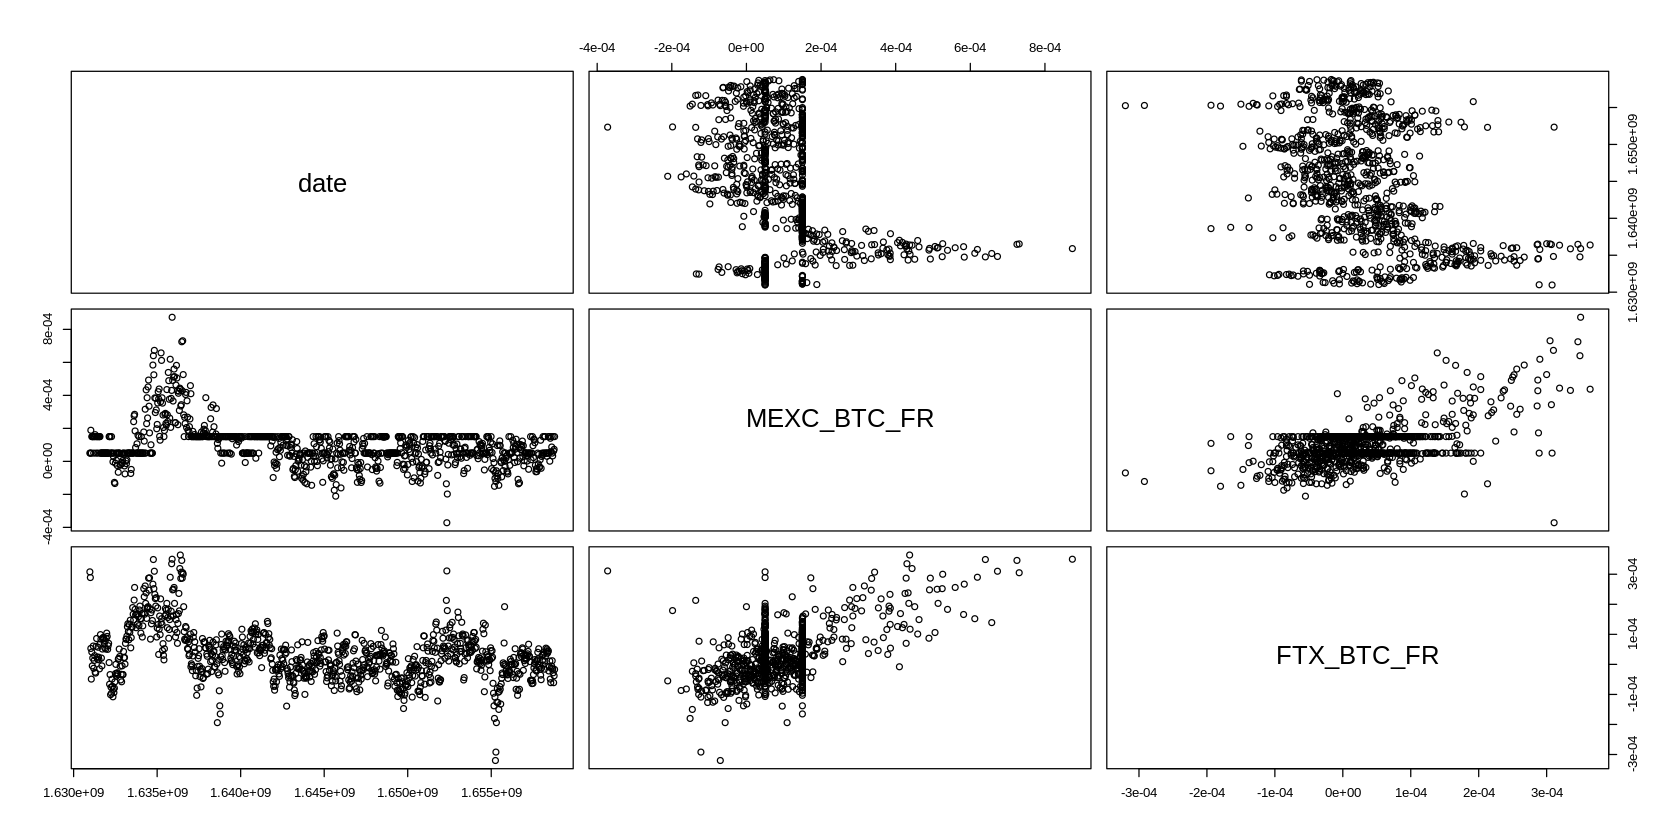

In [ ]:
# combine FRs from 8h MEXC + 8h summarized FTX

FR_pivot <- MEXC_rate %>%
  merge(FTX_rate_8h, all=TRUE) %>% # FTX payments every hour vs. every 8h for MEXC
  filter(date > as.Date("2021-09-01")) %>%
  pivot_wider(names_from=ticker,values_from=rate) %>%
  dplyr::rename(FTX_BTC_FR = "BTC-PERP", MEXC_BTC_FR = BTC_USDT) %>%
  drop_na() %>%
  arrange(date) 
  
FR_pivot %>% head()
FR_pivot %>% plot()

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


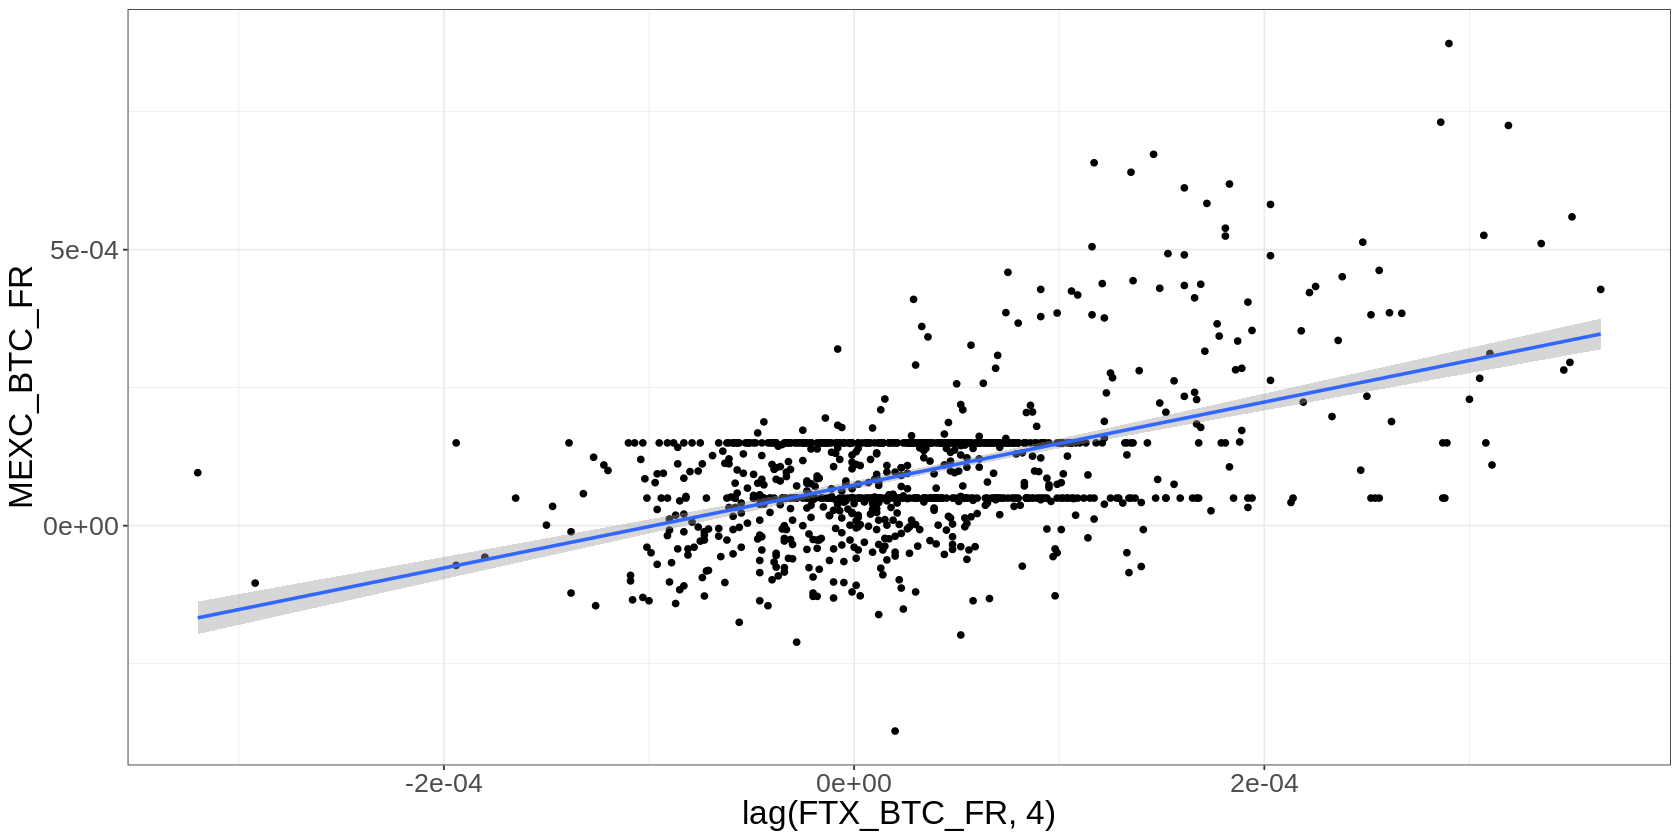

In [ ]:
FR_pivot %>%
  ggplot(aes(y=MEXC_BTC_FR, x=lag(FTX_BTC_FR,4))) + 
  geom_point() +
  geom_smooth(method='lm')

Warning message:
“Removed 9 rows containing non-finite values (stat_poly_line).”
Warning message:
“Removed 9 rows containing non-finite values (stat_poly_eq).”
Warning message:
“Removed 9 rows containing missing values (geom_point).”


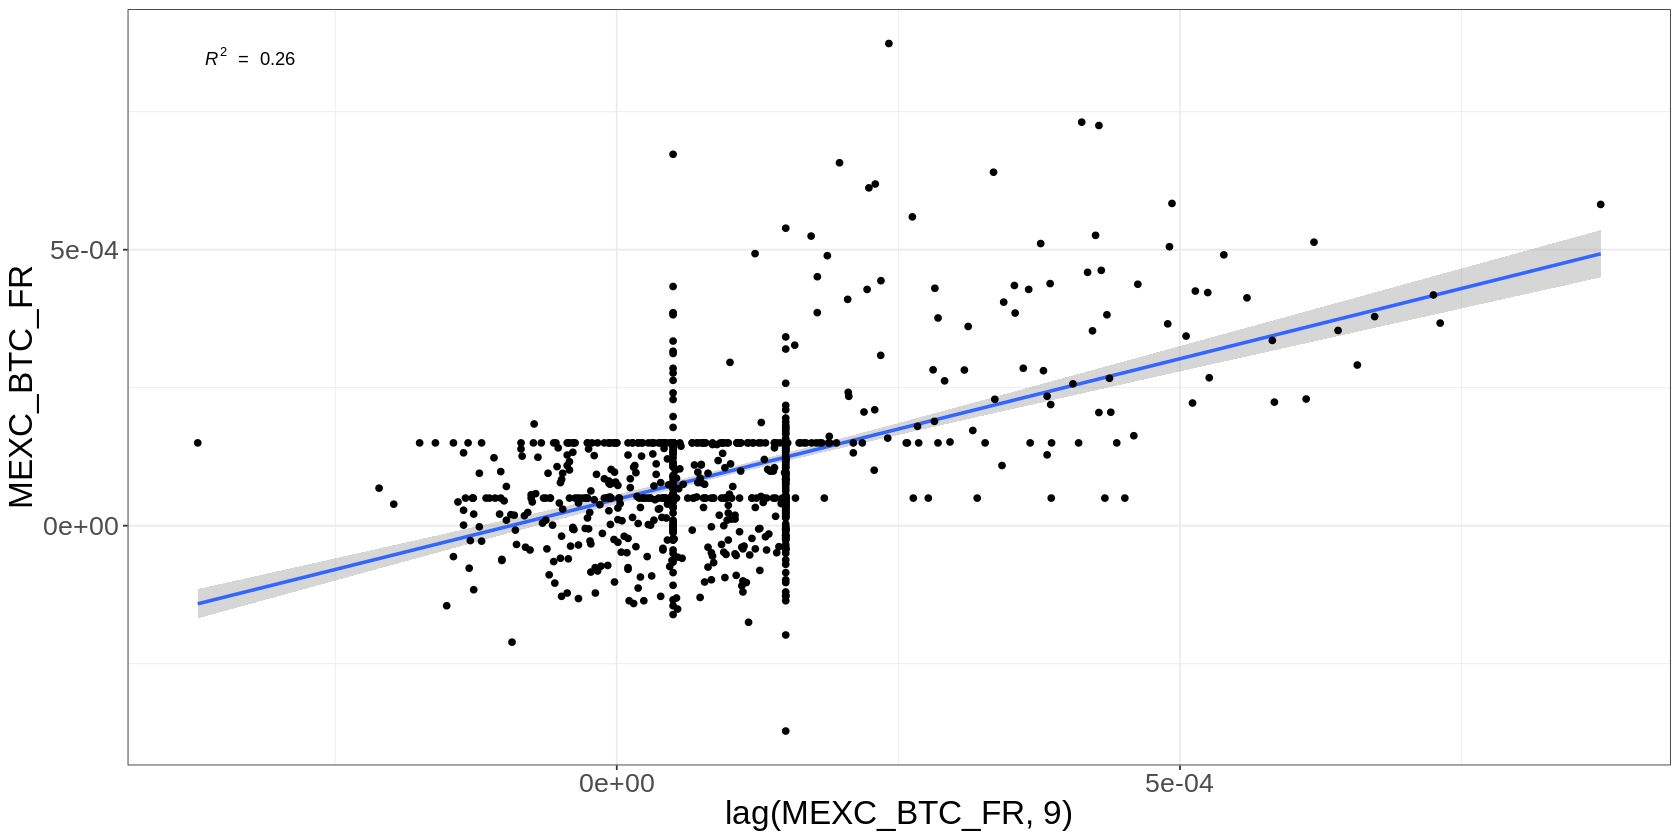

In [ ]:
# install.packages("ggpmisc")
library(ggplot2)
library(ggpmisc)
FR_pivot %>%
  ggplot(aes(x=lag(MEXC_BTC_FR, 9) , y=MEXC_BTC_FR)) + 
    # geom_point() + geom_smooth(method='lm')
  stat_poly_line() +
  stat_poly_eq() +
  geom_point()


Warning message:
“Removed 9 rows containing non-finite values (stat_poly_line).”
Warning message:
“Removed 9 rows containing non-finite values (stat_poly_eq).”
Warning message:
“Removed 9 rows containing missing values (geom_point).”


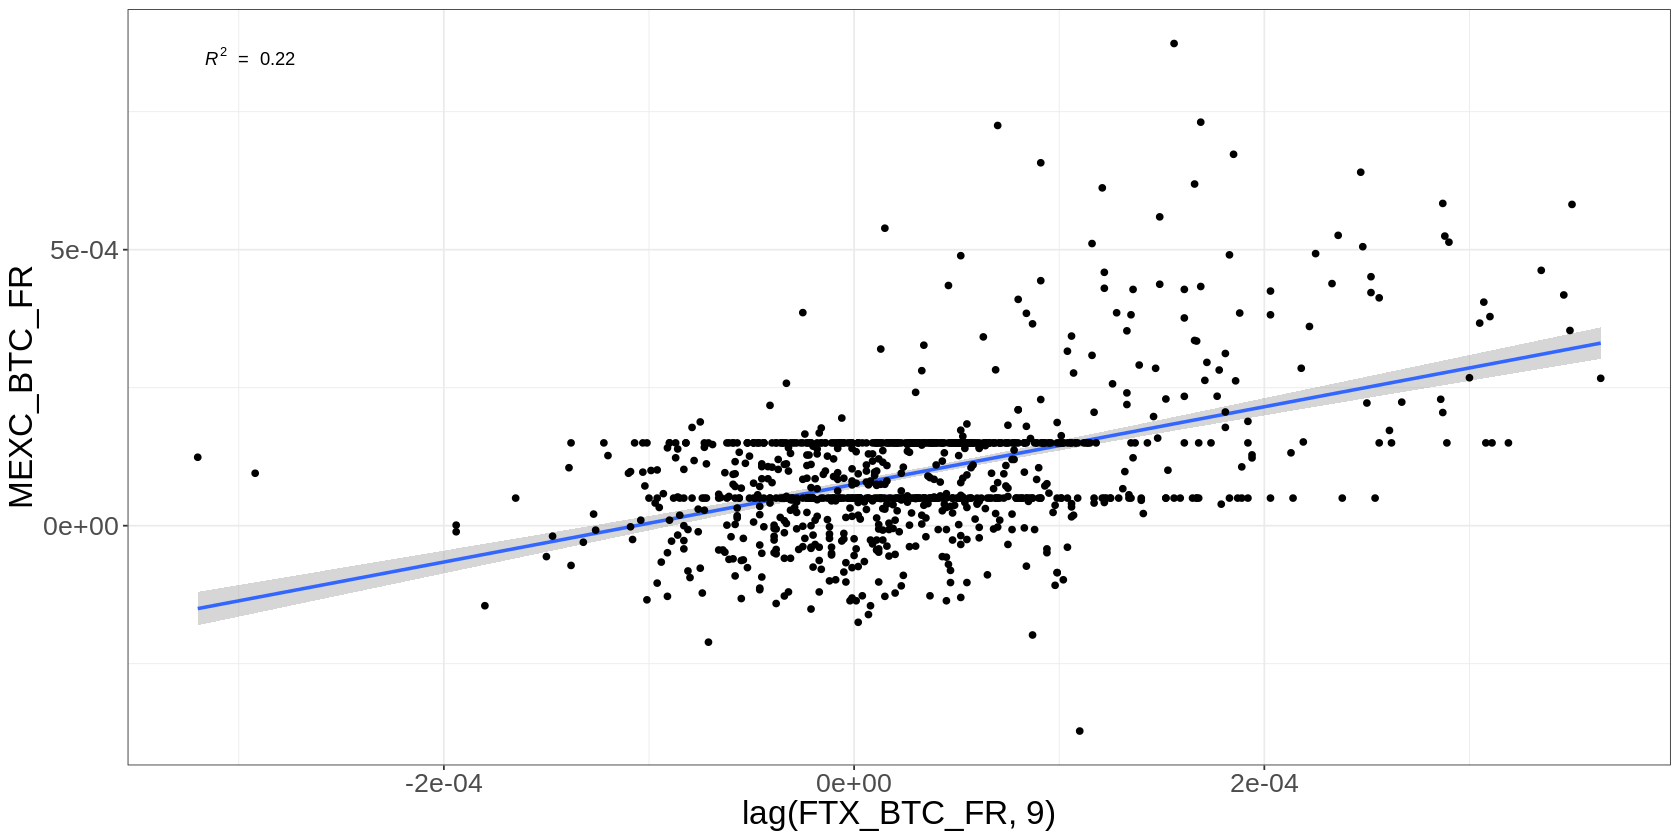

In [ ]:
FR_pivot %>%
  ggplot(aes(x=lag(FTX_BTC_FR, 9) , y=MEXC_BTC_FR)) + 
    # geom_point() + geom_smooth(method='lm') + stat_poly_eq()
  stat_poly_line() +
  stat_poly_eq() +
  geom_point()


Warning message:
“Removed 3 rows containing non-finite values (stat_poly_line).”
Warning message:
“Removed 3 rows containing non-finite values (stat_poly_eq).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


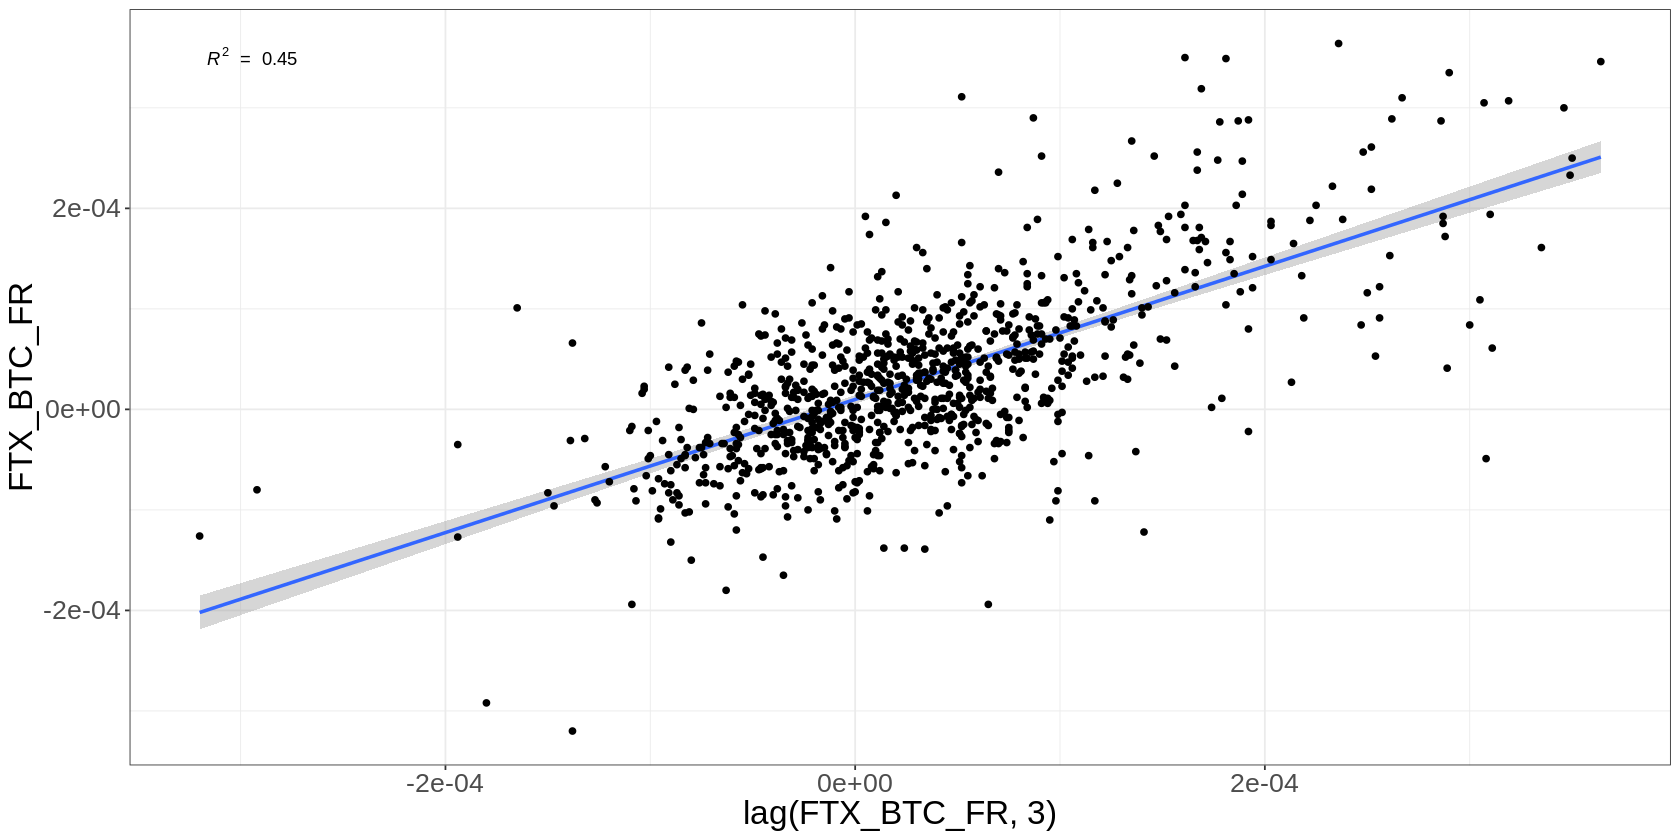

In [ ]:
FR_pivot %>%
  ggplot(aes(x=lag(FTX_BTC_FR, 3) , y=FTX_BTC_FR)) + 
    # geom_point() + geom_smooth(method='lm')
  stat_poly_line() +
  stat_poly_eq() +
  geom_point()


generate lags

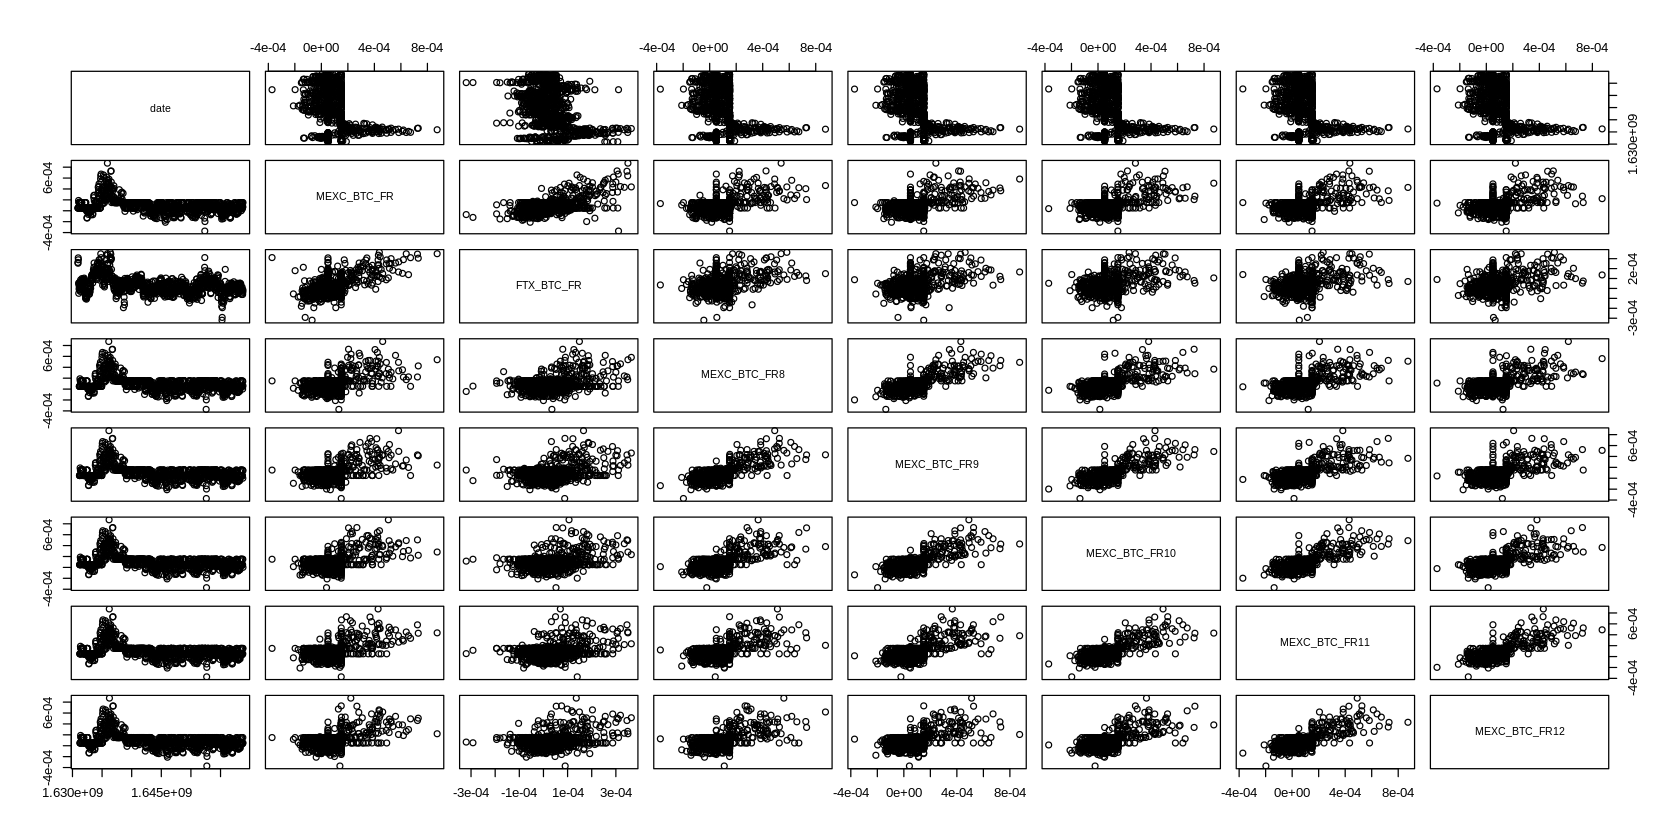

In [ ]:
# FR_pivot
# https://stackoverflow.com/questions/29475411/lag-multiple-variables-multiple-times-in-r
library(data.table)
# setDT(FR_pivot)[, paste0('MEXC_BTC_FR', 1:10) := shift(MEXC_BTC_FR, 1:3)][] %>%
#   plot()

# f <- function(n, k) (1:n*k)[seq(1, n, k)]
setDT(FR_pivot)[, paste0('MEXC_BTC_FR', 8:12) := shift(MEXC_BTC_FR, 8:12)][] %>%
  plot()# + geom_smooth(method='lm')


Warning message:
“Removed 18 row(s) containing missing values (geom_path).”


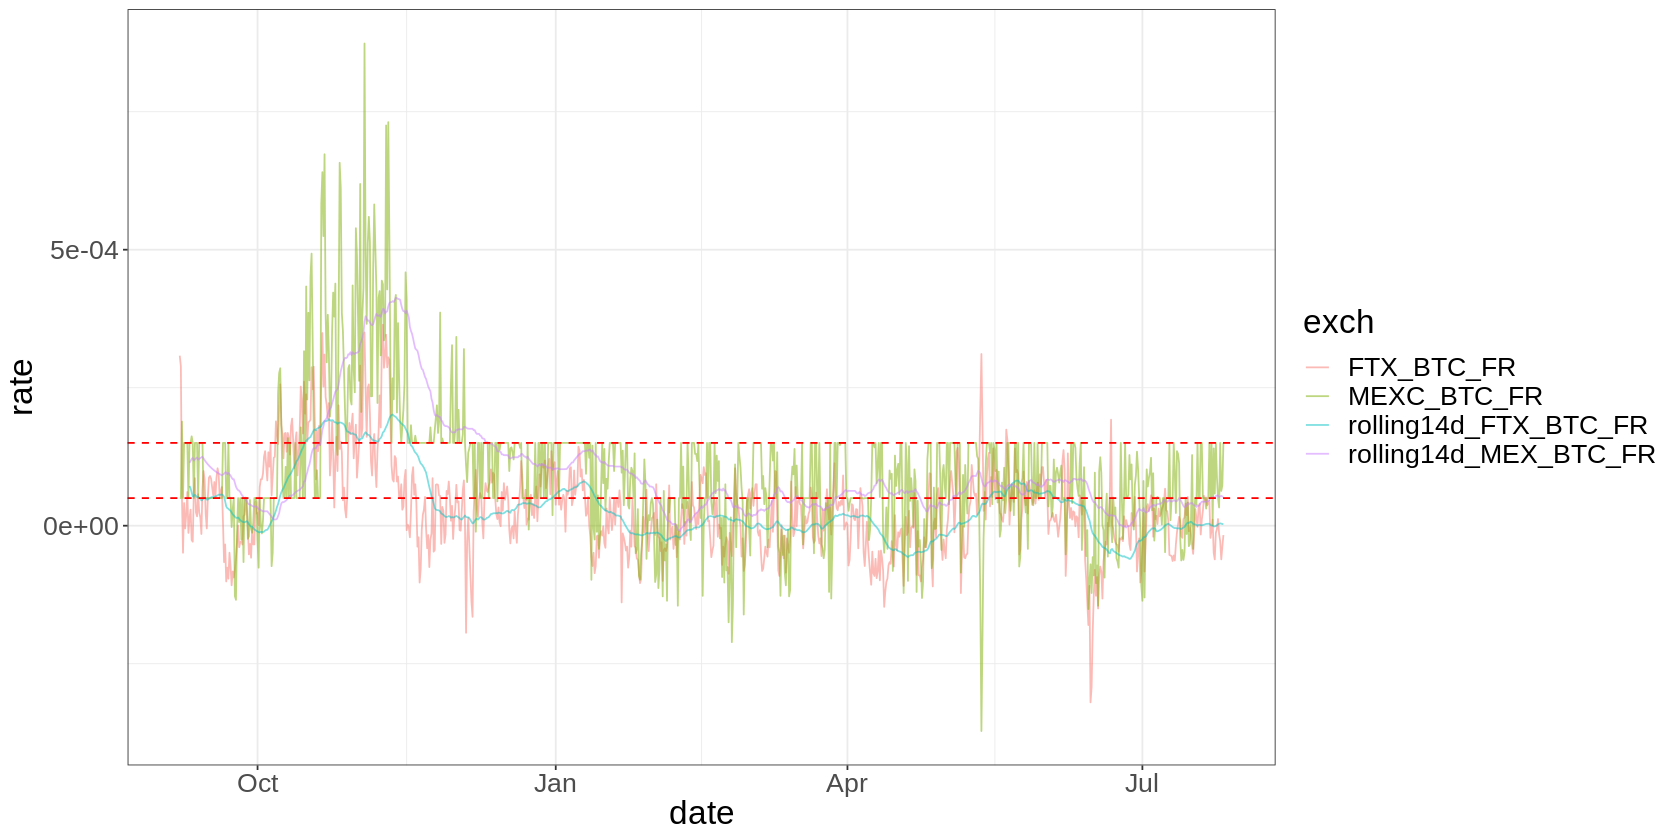

In [ ]:
# identify the two "horizontal lines" on the MEXC perp funding rate (56% of FR are equal to either of the two data points)
mexc_hlines <- FR_pivot %>% 
  select(MEXC_BTC_FR) %>%
  table() %>% as_tibble() %>% arrange(desc(n)) %>%
  head(2) %>%
  mutate(MEXC_BTC_FR = as.numeric(MEXC_BTC_FR)) %>%
  select(MEXC_BTC_FR) %>%
  arrange(1)

# chart with FR & horizontal lines where MEXC caps out often
FR_pivot %>% select(date, MEXC_BTC_FR, FTX_BTC_FR) %>%
  mutate(rolling14d_MEX_BTC_FR = roll_mean(FR_pivot$MEXC_BTC_FR, width=3*14, min_obs = 10)) %>%
  mutate(rolling14d_FTX_BTC_FR = roll_mean(FR_pivot$FTX_BTC_FR, width=3*14, min_obs = 10)) %>%
  # ggplot(aes(x=date, y=rolling_MEX_BTC_FR)) + geom_line()# + geom_smooth(method='lm')
  pivot_longer(-date, names_to="exch", values_to="rate") %>%
  ggplot(aes(color=exch, x=date, y=rate)) + 
    geom_line(alpha=.5) +
    geom_hline(yintercept=mexc_hlines[[1,1]], linetype="dashed", color = "red") +
    geom_hline(yintercept=mexc_hlines[[2,1]], linetype="dashed", color = "red")

Top

In [ ]:
mexc_hlines

MEXC_BTC_FR
1 0.00015    
2 0.00005

**56% of FR rates are one of two set rates!**

In [ ]:
FR_pivot %>% 
  select(MEXC_BTC_FR) %>%
  table() %>% as_tibble() %>% arrange(desc(n)) %>%
  head(2)

FR_pivot %>% 
  select(MEXC_BTC_FR) %>%
  table() %>% as_tibble() %>% arrange(desc(n)) %>%
  head(2) %>% select(n) %>% sum() / length(FR_pivot)


MEXC_BTC_FR n  
1 0.00015     256
2 5e-05       191

[1] 55.875

--------------------------------------------------------------------------
# D. Identify predictor to the "side" of MEXC's FR vs the two "horizontal lines"

Map rows with the "side" of the per rate
-   0 = between the 2 dotted lines
-   1 = below
-   2 = above

In [ ]:
mexc_hlines <- FR_pivot %>% 
  select(MEXC_BTC_FR) %>%
  table() %>% as_tibble() %>% arrange(desc(n)) %>%
  head(2) %>%
  mutate(MEXC_BTC_FR = as.numeric(MEXC_BTC_FR)) %>%
  select(MEXC_BTC_FR) %>%
  arrange(1)

# side categorization (1 per date for MEXC's FR):
#   0 = between the 2 dotted lines
#   1 = below
#   2 = above
FR_pivot_sides <- FR_pivot %>% 
  mutate(side = case_when(
    mexc_hlines[[2,1]] <= FR_pivot$MEXC_BTC_FR & FR_pivot$MEXC_BTC_FR <= mexc_hlines[[1,1]] ~ 0,
    FR_pivot$MEXC_BTC_FR < mexc_hlines[[2,1]] ~ 1,
    TRUE ~ 2)) %>%
    select(date, side)

# merge w/ long df
FR_pivot %>% select(date, MEXC_BTC_FR, FTX_BTC_FR) %>%
  mutate(rolling7d_MEX_BTC_FR = roll_mean(FR_pivot$MEXC_BTC_FR, width=3*7, min_obs = 10)) %>%
  mutate(rolling7d_FTX_BTC_FR = roll_mean(FR_pivot$FTX_BTC_FR, width=3*7, min_obs = 10)) %>%
  pivot_longer(-date, names_to="exch", values_to="rate")  %>%
  merge(FR_pivot_sides, all=TRUE) %>% head()


date                exch                 rate     side
1 2021-09-06 08:00:00 MEXC_BTC_FR          0.000050 0   
2 2021-09-06 08:00:00 FTX_BTC_FR           0.000262 0   
3 2021-09-06 08:00:00 rolling7d_MEX_BTC_FR       NA 0   
4 2021-09-06 08:00:00 rolling7d_FTX_BTC_FR       NA 0   
5 2021-09-06 16:00:00 MEXC_BTC_FR          0.000050 0   
6 2021-09-06 16:00:00 FTX_BTC_FR           0.000254 0

In [ ]:
FR_pivot %>% select(date, MEXC_BTC_FR, FTX_BTC_FR) %>%
  mutate(rolling7d_MEX_BTC_FR = roll_mean(FR_pivot$MEXC_BTC_FR, width=3*7, min_obs = 10)) %>%
  mutate(rolling7d_FTX_BTC_FR = roll_mean(FR_pivot$FTX_BTC_FR, width=3*7, min_obs = 10)) %>%
  pivot_longer(-date, names_to="exch", values_to="FTX_BTC_FR")  %>%
  merge(FR_pivot_sides, all=TRUE)  %>% head()
  ggplot(aes(x=FTX_BTC_FR, color=exch)) +
    # geom_histogram()+
    geom_density(alpha=.2) 


date                exch                 FTX_BTC_FR side
1 2021-09-06 08:00:00 MEXC_BTC_FR          0.000050   0   
2 2021-09-06 08:00:00 FTX_BTC_FR           0.000262   0   
3 2021-09-06 08:00:00 rolling7d_MEX_BTC_FR       NA   0   
4 2021-09-06 08:00:00 rolling7d_FTX_BTC_FR       NA   0   
5 2021-09-06 16:00:00 MEXC_BTC_FR          0.000050   0   
6 2021-09-06 16:00:00 FTX_BTC_FR           0.000254   0

Chart 1 hist / side

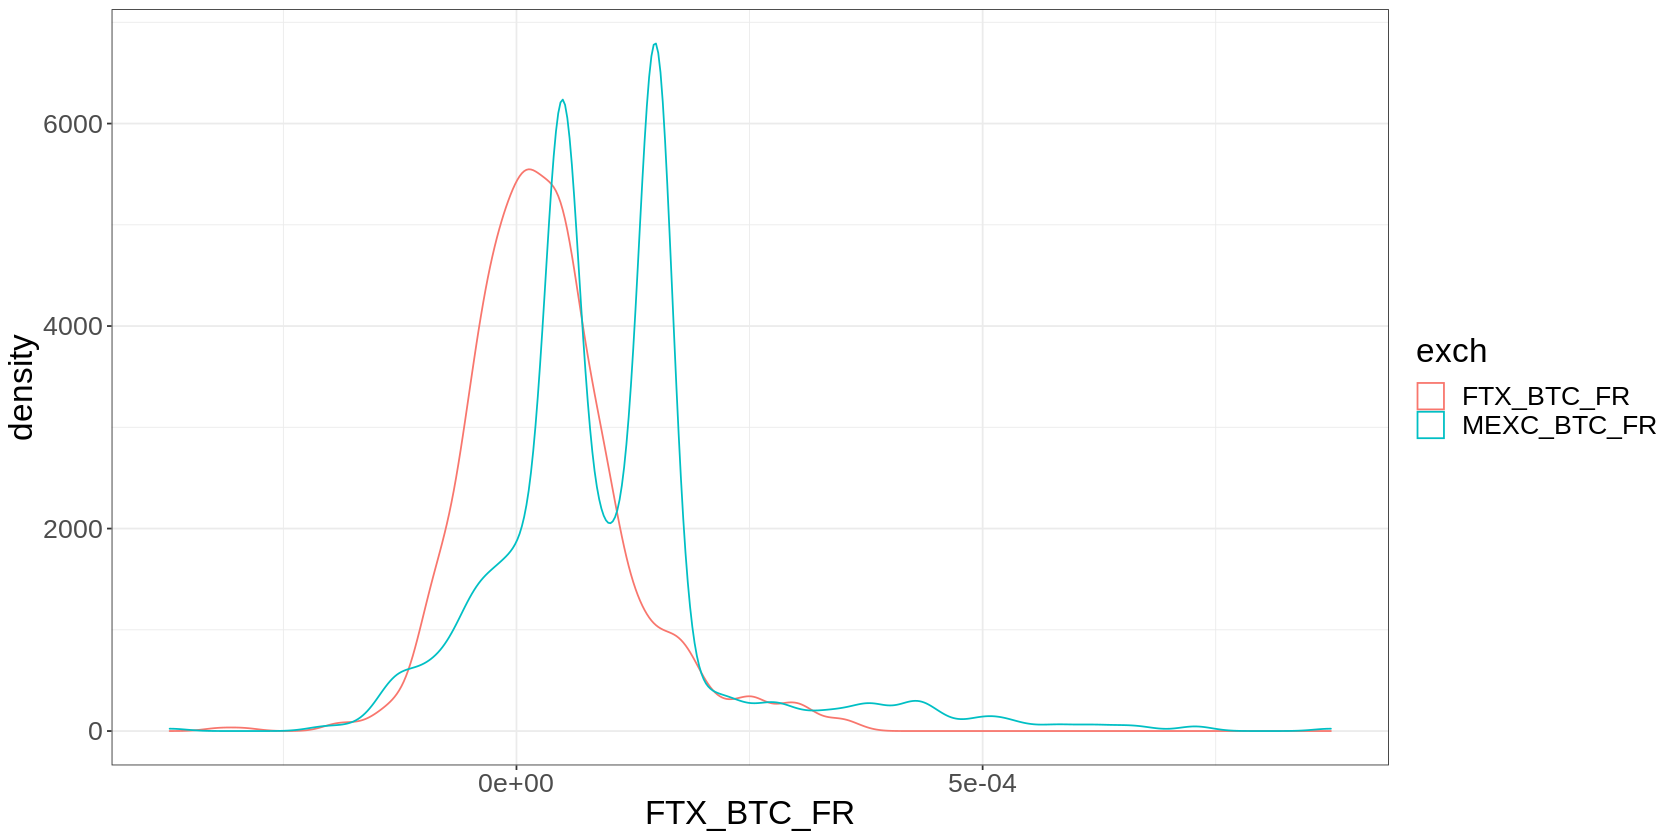

In [ ]:
FR_pivot %>% select(date, MEXC_BTC_FR, FTX_BTC_FR) %>%
  pivot_longer(-date, names_to="exch", values_to="FTX_BTC_FR")  %>%
  merge(FR_pivot_sides, all=TRUE)  %>% #select(side) %>% table() %>% as_tibble()
  ggplot(aes(x=FTX_BTC_FR, color=exch)) +
    # geom_histogram()+
    geom_density(alpha=.2) 



Warning message:
“Removed 21 rows containing non-finite values (stat_density).”


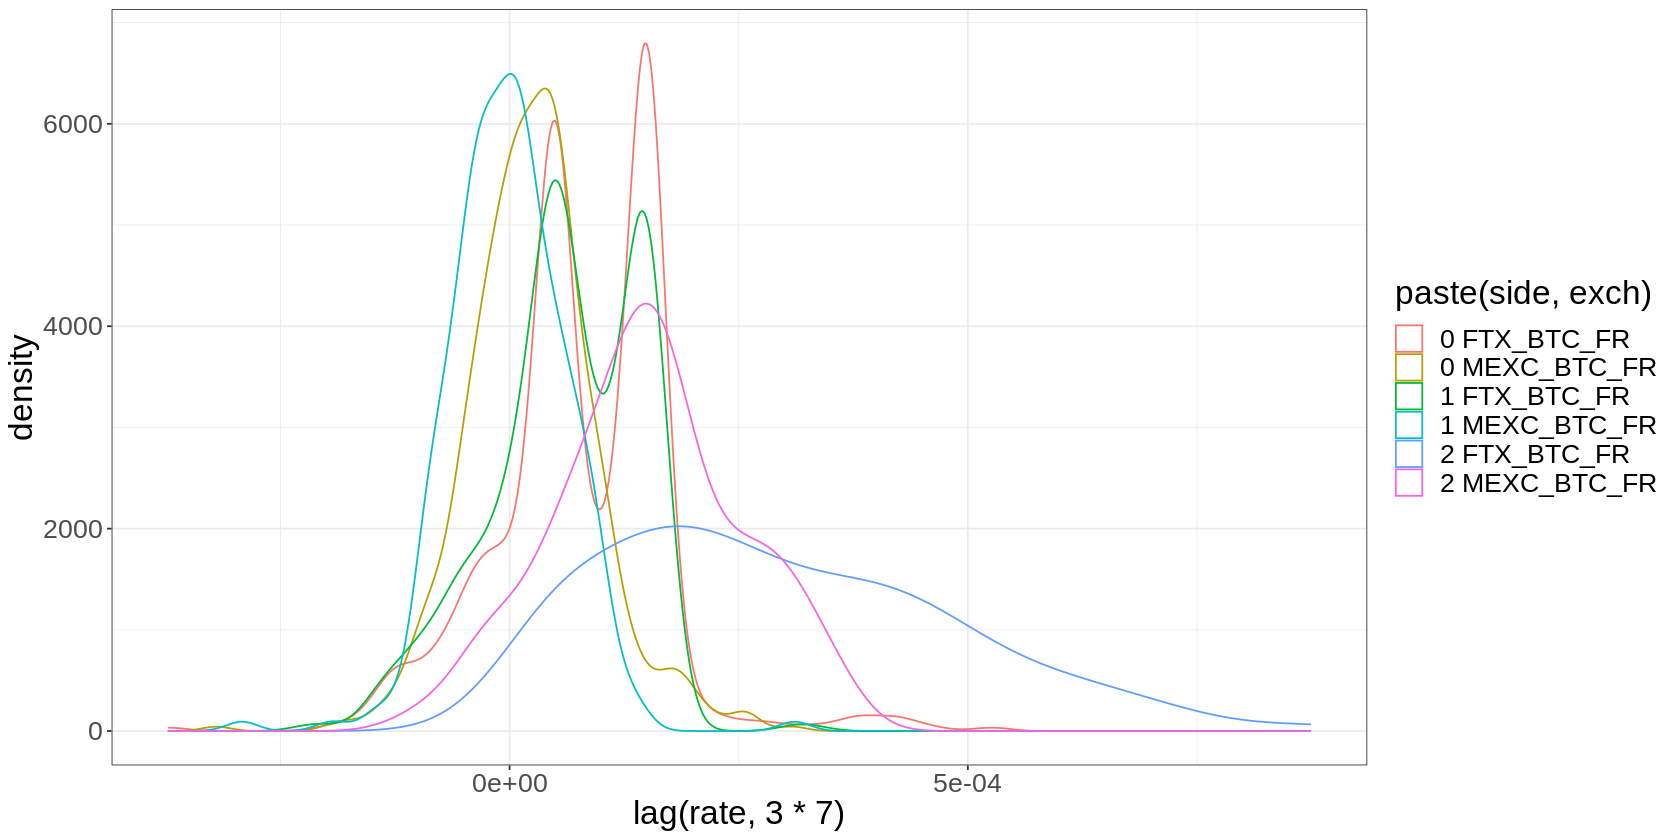

In [ ]:
FR_pivot %>% select(date, FTX_BTC_FR, MEXC_BTC_FR) %>%
  # mutate(rolling7d_MEX_BTC_FR = roll_mean(FR_pivot$MEXC_BTC_FR, width=3*7, min_obs = 10)) %>%
  # mutate(rolling7d_FTX_BTC_FR = roll_mean(FR_pivot$FTX_BTC_FR, width=3*7, min_obs = 10)) %>%
  # # Only keep those we want to analyze
  # select(date, FTX_BTC_FR, MEXC_BTC_FR) %>%
  pivot_longer(-date, names_to="exch", values_to="rate")  %>%
  merge(FR_pivot_sides, all=TRUE)  %>% #select(side) %>% table() %>% as_tibble()
  mutate(side = paste(side)) %>%
  ggplot(aes(x=lag(rate,3*7), color=paste(side, exch))) +
    # geom_histogram()+
    geom_density(alpha=.2) 



Warning message:
“Removed 9 rows containing non-finite values (stat_density).”


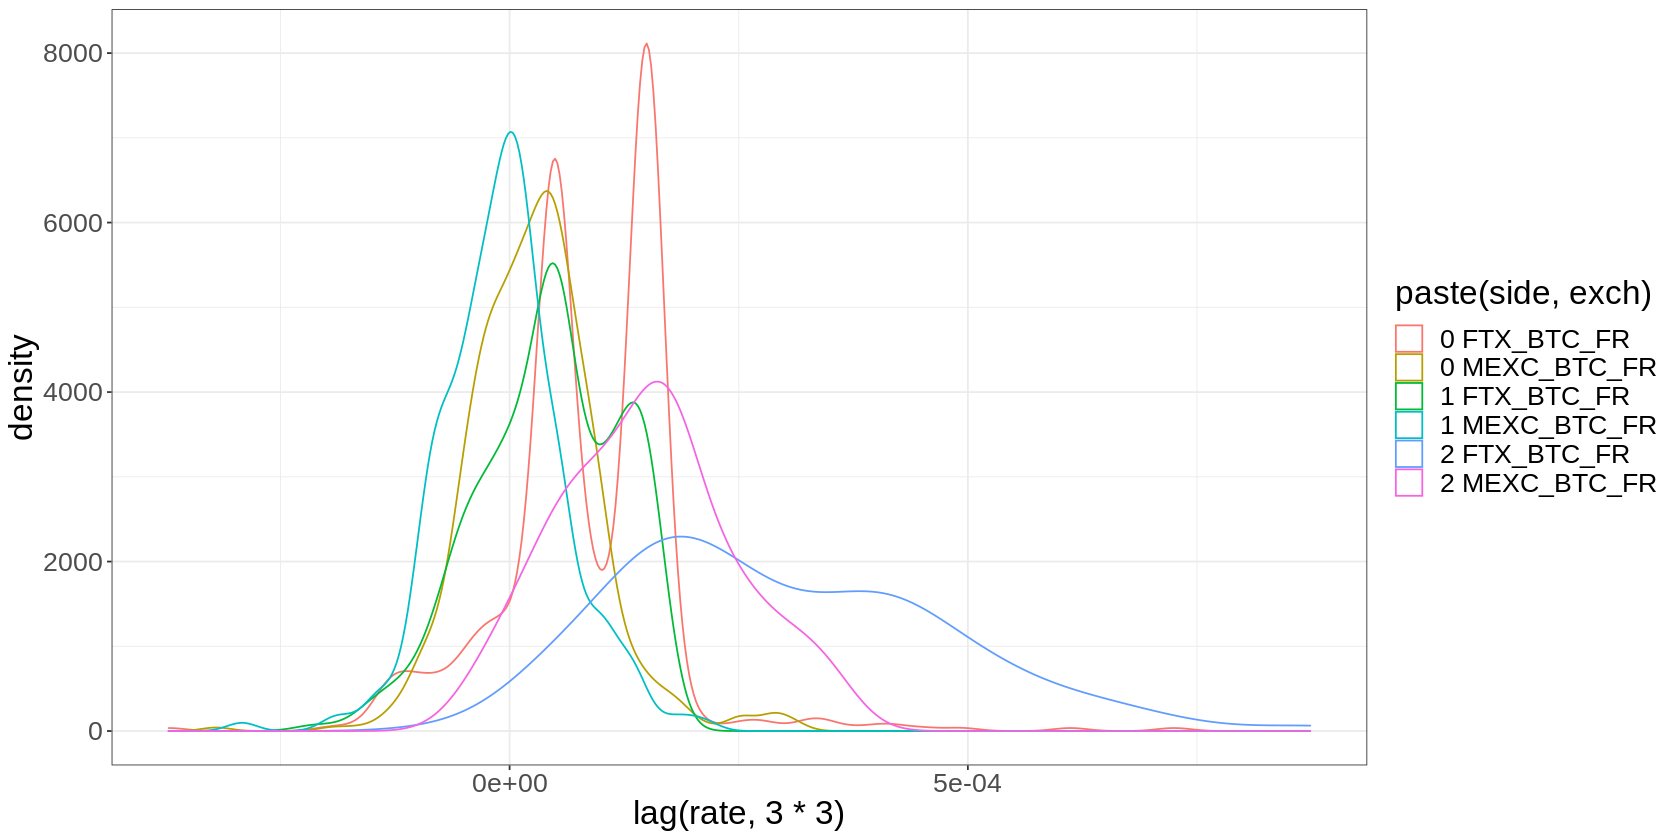

In [ ]:
FR_pivot %>% select(date, FTX_BTC_FR, MEXC_BTC_FR) %>%
  # mutate(rolling7d_MEX_BTC_FR = roll_mean(FR_pivot$MEXC_BTC_FR, width=3*7, min_obs = 10)) %>%
  # mutate(rolling7d_FTX_BTC_FR = roll_mean(FR_pivot$FTX_BTC_FR, width=3*7, min_obs = 10)) %>%
  # # Only keep those we want to analyze
  # select(date, FTX_BTC_FR, MEXC_BTC_FR) %>%
  pivot_longer(-date, names_to="exch", values_to="rate")  %>%
  merge(FR_pivot_sides, all=TRUE)  %>% #select(side) %>% table() %>% as_tibble()
  mutate(side = paste(side)) %>%
  ggplot(aes(x=lag(rate,3*3), color=paste(side, exch))) +
    # geom_histogram()+
    geom_density(alpha=.2) 



# Key results

1. FTX offers strong predictability into bucket 2 (high values) for the BTC MEXC perp
2. Mid and low buckets (0 & 1) cannot be easily separated with just the FR history

Warning message:
“Removed 3 rows containing non-finite values (stat_density).”
Warning message:
“Removed 3 rows containing non-finite values (stat_density).”


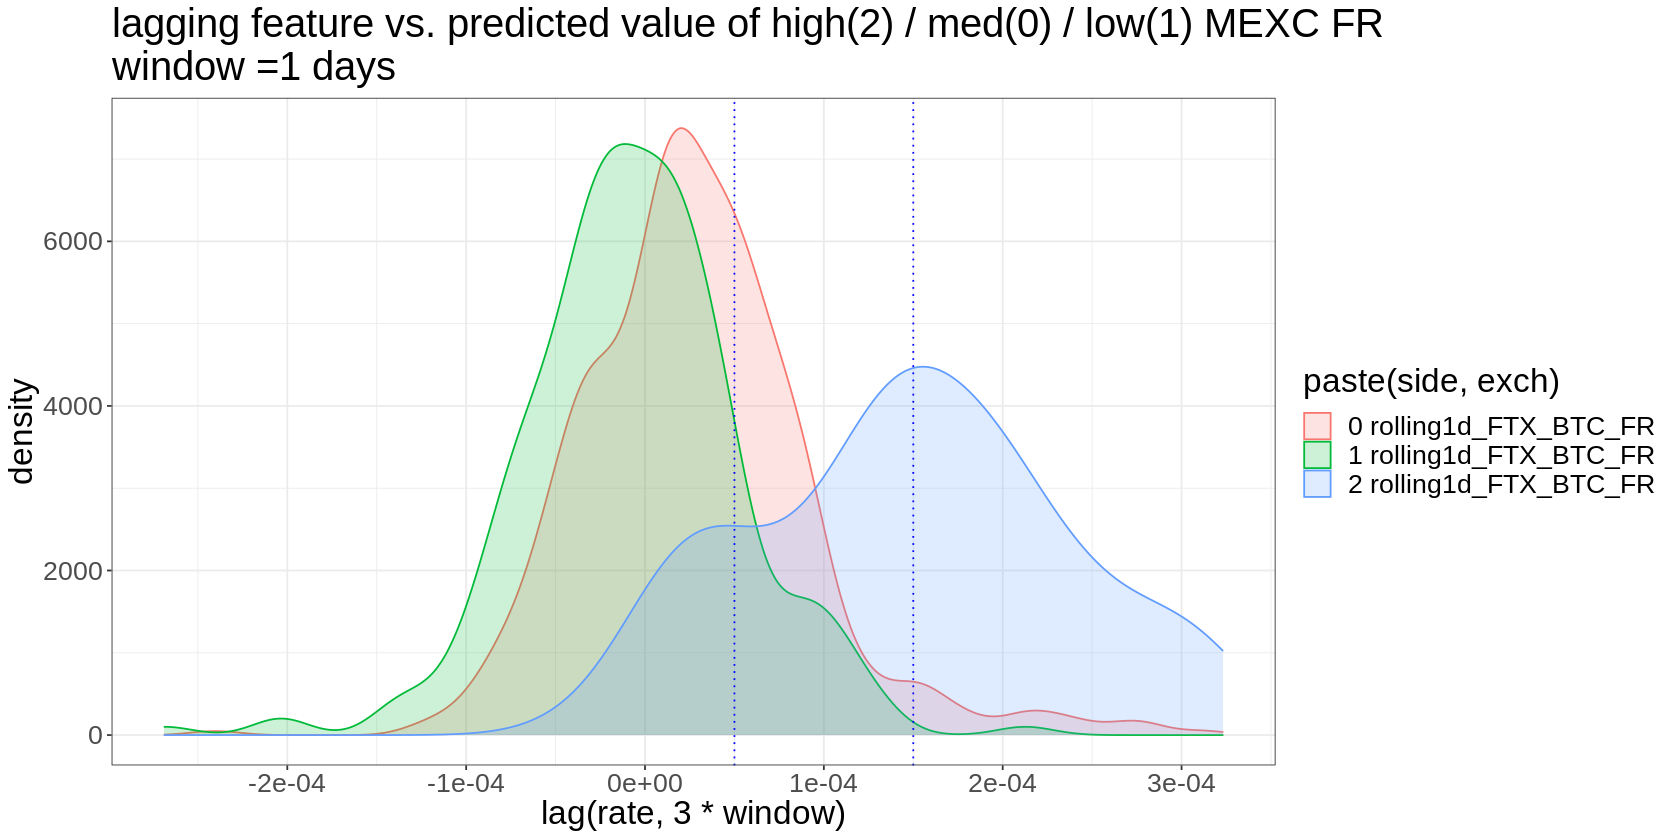

Warning message:
“Removed 15 rows containing non-finite values (stat_density).”


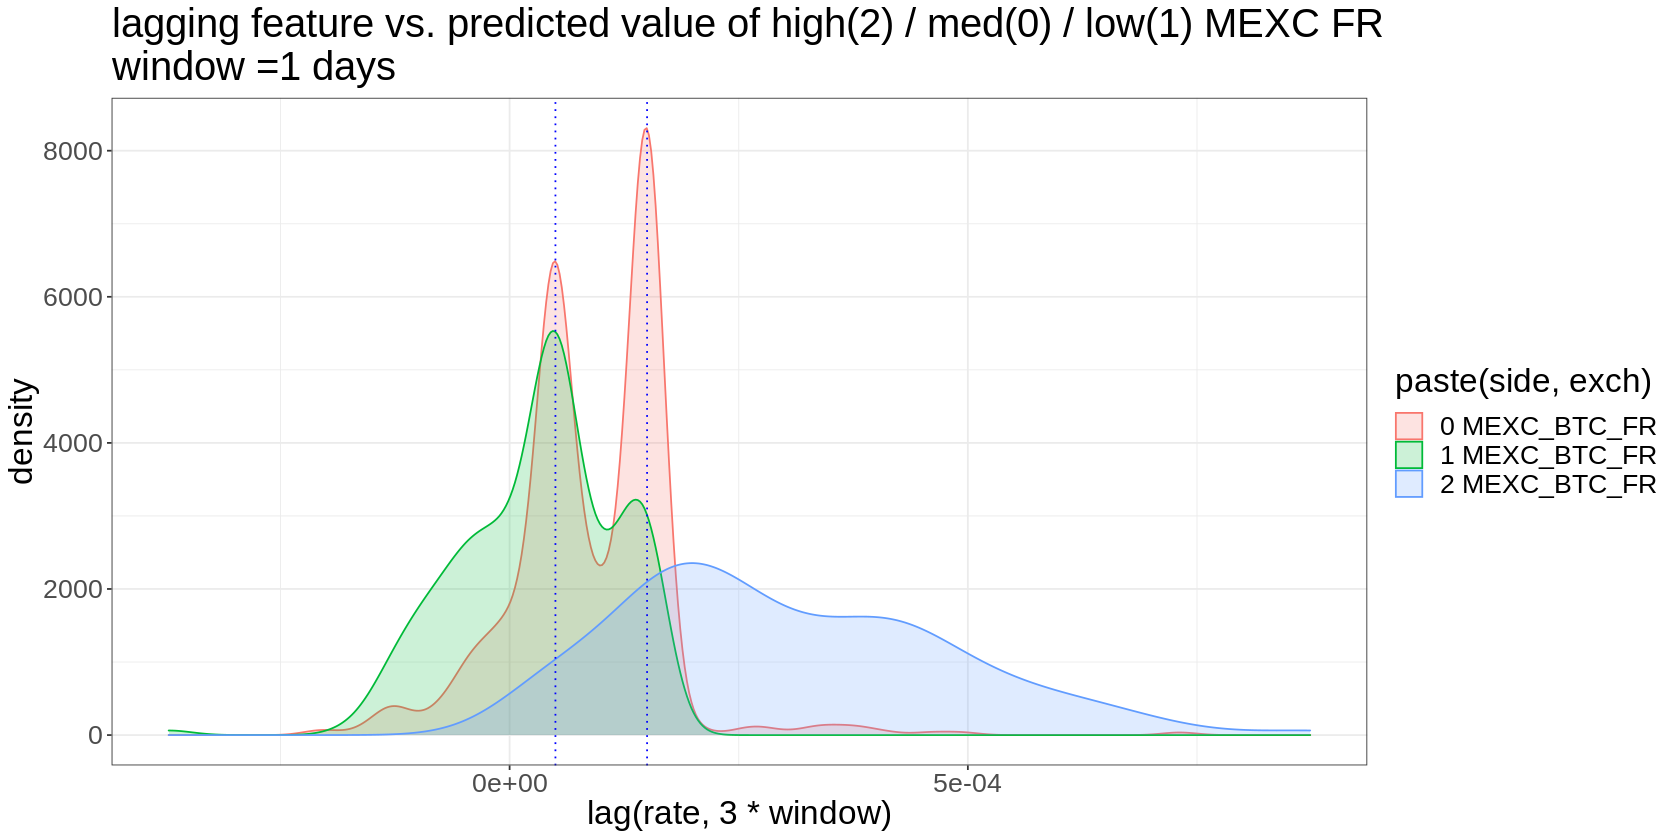

Warning message:
“Removed 12 rows containing non-finite values (stat_density).”


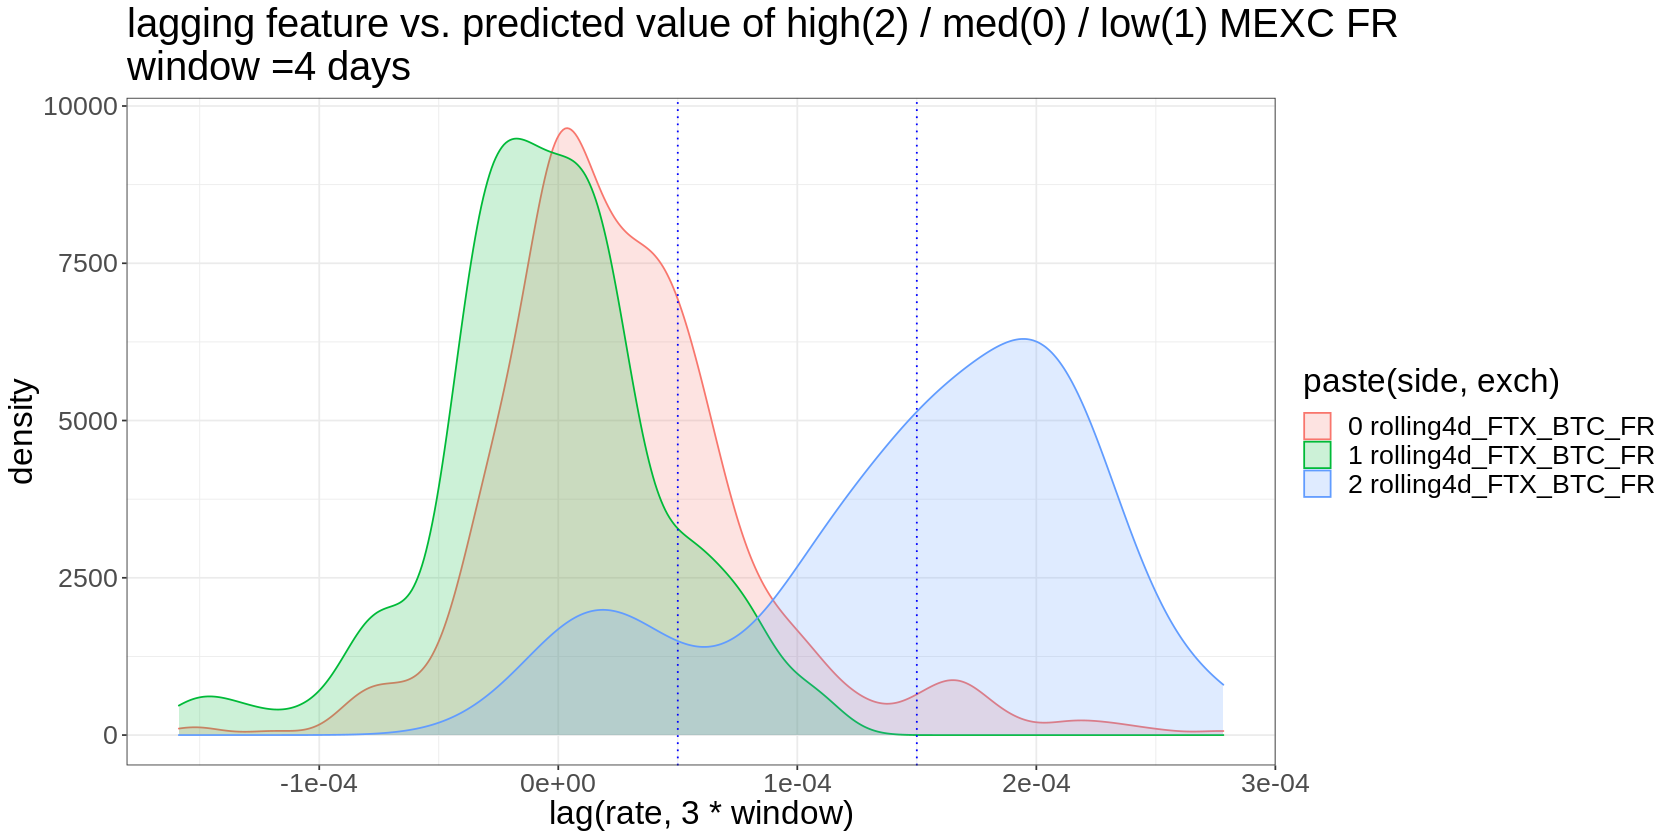

Warning message:
“Removed 54 rows containing non-finite values (stat_density).”


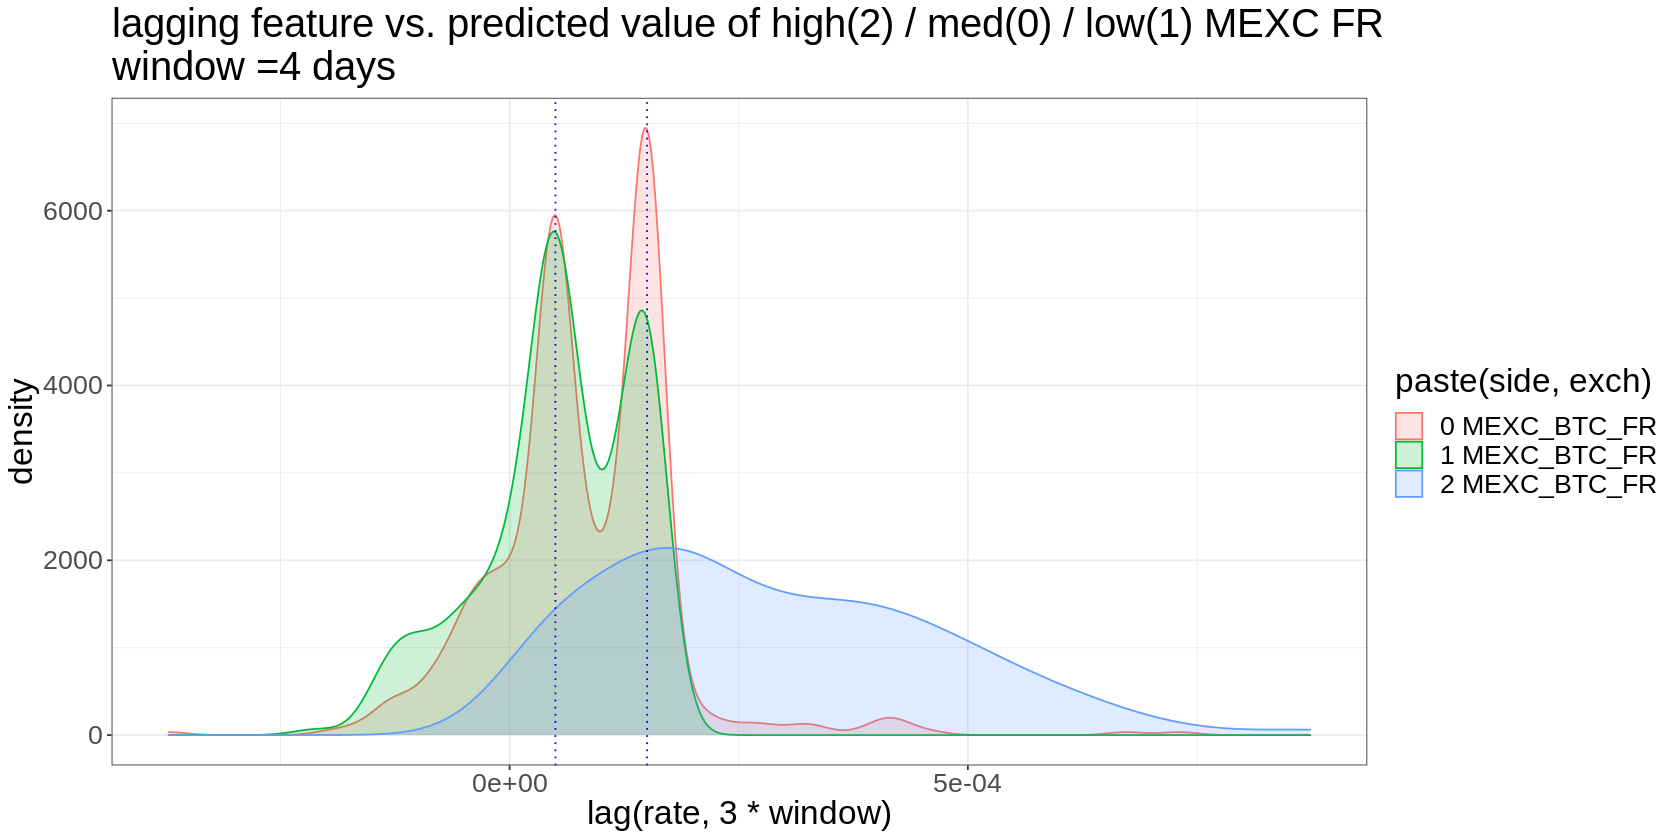

Warning message:
“Removed 45 rows containing non-finite values (stat_density).”


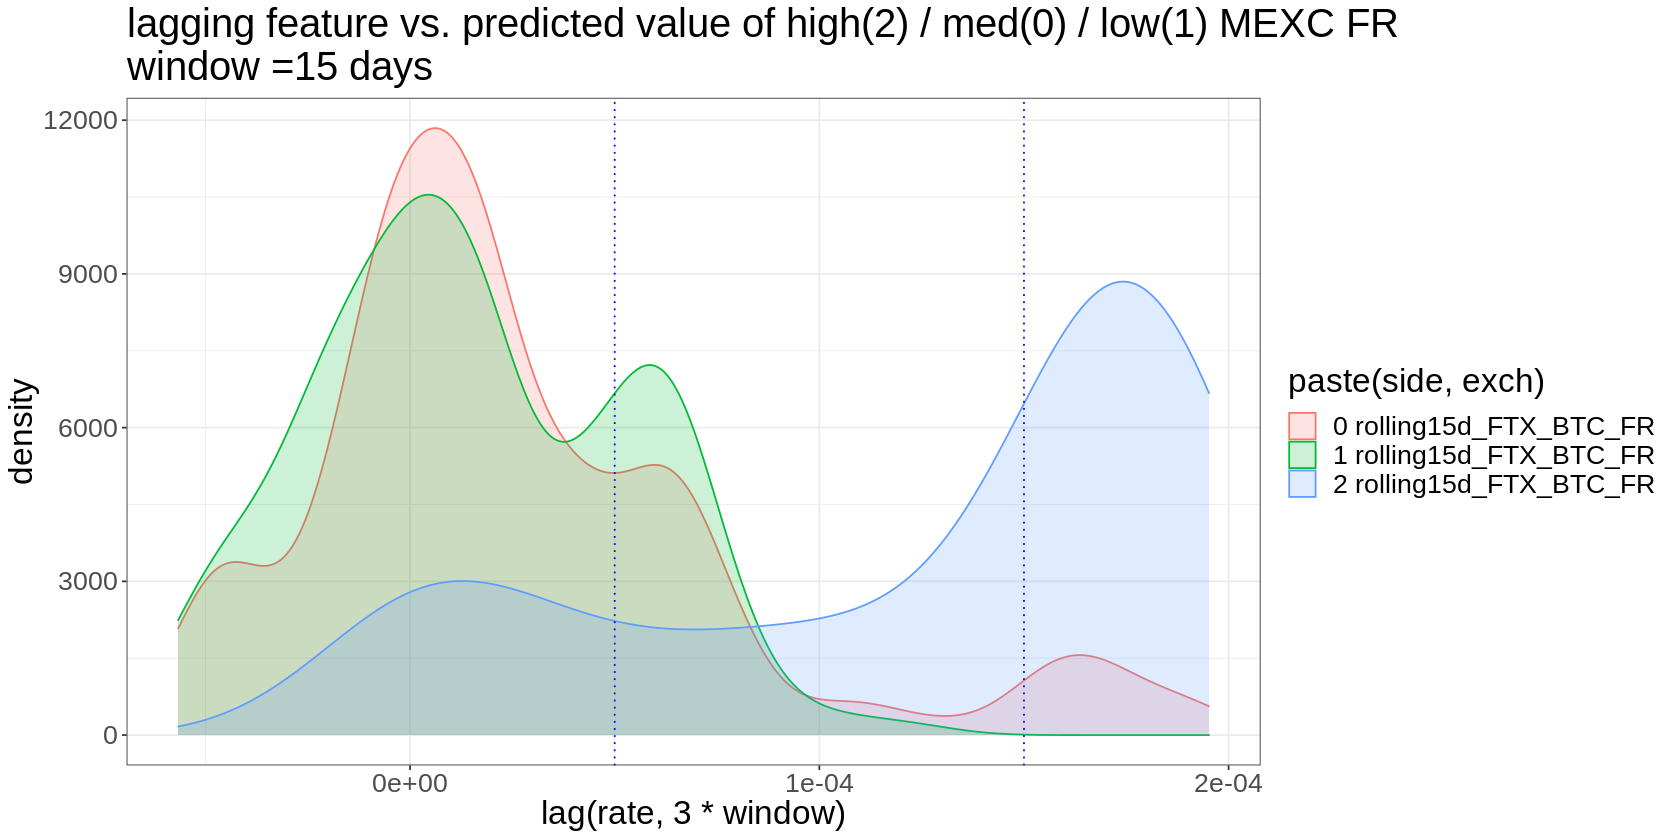

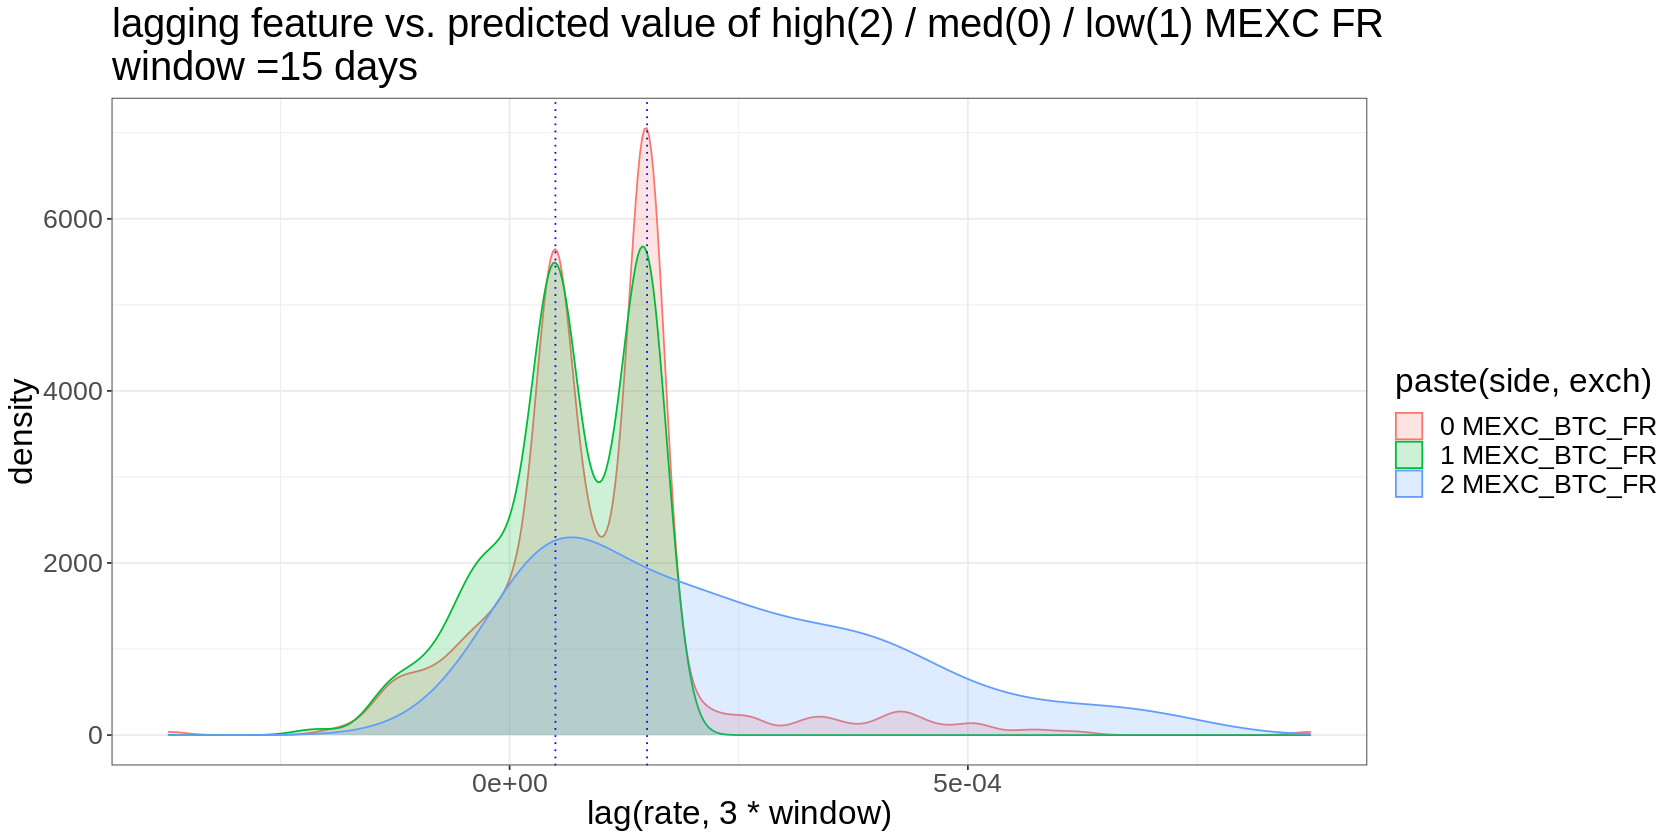

In [ ]:
mexc_hlines <- FR_pivot %>% 
  select(MEXC_BTC_FR) %>%
  table() %>% as_tibble() %>% arrange(desc(n)) %>%
  head(2) %>%
  mutate(MEXC_BTC_FR = as.numeric(MEXC_BTC_FR)) %>%
  select(MEXC_BTC_FR) %>%
  arrange(1)

plot_FR_pred <- function(show_mexc=TRUE, window=7) {
  FR_pivot %>% select(date, FTX_BTC_FR, MEXC_BTC_FR) %>%
    mutate("rolling{window}d_FTX_BTC_FR" := roll_mean(FR_pivot$FTX_BTC_FR, width=3*window, min_obs = min(window, 10))) %>%
    mutate("rolling{window}d_MEX_BTC_FR" := roll_mean(FR_pivot$MEXC_BTC_FR, width=3*window, min_obs = min(window, 10))) %>%
    # # Only keep those we want to analyze
    select(date, case_when(show_mexc ~ 3, TRUE ~ 4)) %>%
    pivot_longer(-date, names_to="exch", values_to="rate")  %>%
    merge(FR_pivot_sides, all=TRUE)  %>% #select(side) %>% table() %>% as_tibble()
    mutate(side = paste(side)) %>%
    ggplot(aes(x=lag(rate,3*window), color=paste(side, exch), fill=paste(side, exch))) +
      # geom_histogram()+
      geom_density(alpha=.2) + 
      geom_vline(xintercept = mexc_hlines[[1,1]], linetype="dotted", 
                color = "blue", size=0.5) + 
      geom_vline(xintercept = mexc_hlines[[2,1]], linetype="dotted", 
                color = "blue", size=0.5) +
      labs(title=glue("lagging feature vs. predicted value of high(2) / med(0) / low(1) MEXC FR \nwindow ={window} days"))
}

window <- 1
plot_FR_pred(show_mexc=FALSE, window=window)
plot_FR_pred(show_mexc=TRUE, window=window)

window <- 4
plot_FR_pred(show_mexc=FALSE, window=window)
plot_FR_pred(show_mexc=TRUE, window=window)

window <- 15
plot_FR_pred(show_mexc=FALSE, window=window)
plot_FR_pred(show_mexc=TRUE, window=window)


55% of the FTX values are (strongly) predictive of MEXC FR bucket 2 (short perp, long underlying)

In [ ]:
# per charts above, 4 days lag FTX FR > 1e-04 means that MEXC FR will be in bucket 2 (high == above mexc_hlines[[1,1]] )
ftx_pred_cutoff <- 1e-04

window <- 4
FR_pivot %>%
  mutate("rolling{window}d_FTX_BTC_FR" := roll_mean(FR_pivot$FTX_BTC_FR, 
         width = 3*window, 
         min_obs = max(window, 10))) %>%
  drop_na() %>%
  filter(glue("rolling{window}d_FTX_BTC_FR") > ftx_pred_cutoff ) %>% 
  .[[1]] %>% length() / length(FTX_rate_8h[[1]])


[1] 0.5580175

Number of trades: 5


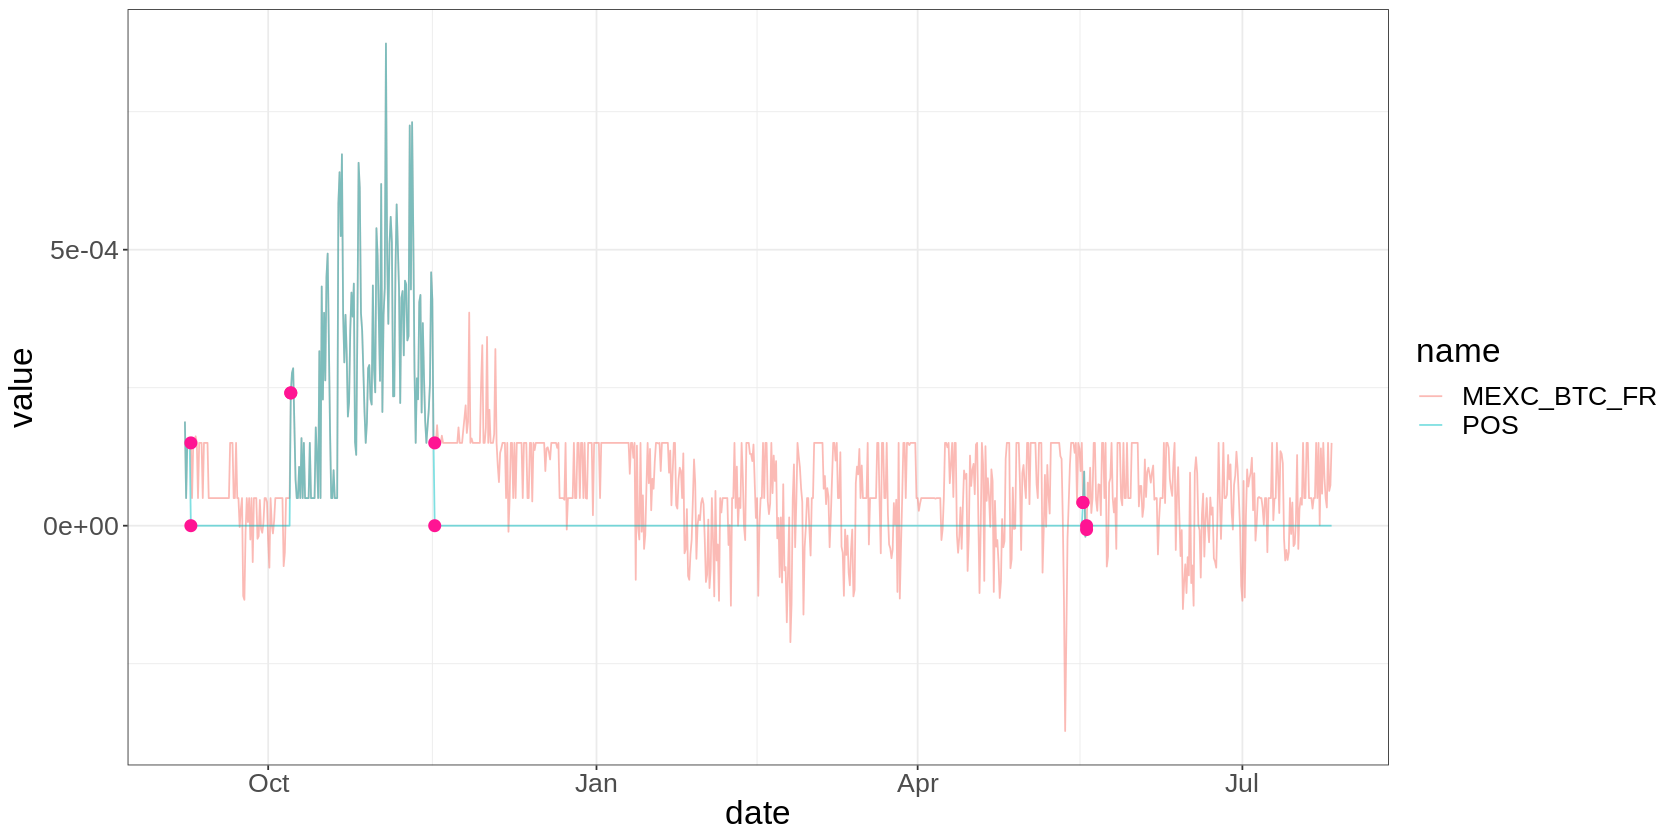

In [ ]:
# STRATEGY 1. use FTX last 3-6 days as pred for next day
ftx_pred_cutoff <- 1e-04 
window <- 3*6
pred_lag <- 1
FR_pivot %>%
  select(date, MEXC_BTC_FR, FTX_BTC_FR) %>%
  mutate(rollingNd_FTX_BTC_FR = roll_mean(FR_pivot$FTX_BTC_FR, 
                                          width=window, 
                                          min_obs = 1)) %>%
  mutate(MEXC_PRED_3d = lag(rollingNd_FTX_BTC_FR, pred_lag) > ftx_pred_cutoff) %>%
  mutate(trade = MEXC_PRED_3d != lag(MEXC_PRED_3d)) %>%
  drop_na() %>%
  mutate(POS=case_when(MEXC_PRED_3d ~ MEXC_BTC_FR, TRUE~0)) %>%
  select(date, POS, MEXC_BTC_FR, trade) %>%
  pivot_longer(-c(date, trade)) %>%
  ggplot(aes(x=date, y=value, color=name)) + 
    geom_line(alpha=.5) +
    geom_point(data = . %>% filter(trade == TRUE), color = "deeppink", size = 3)

print_(glue("Number of trades: {
FR_pivot %>%
  select(date, MEXC_BTC_FR, FTX_BTC_FR) %>%
  mutate(rollingNd_FTX_BTC_FR = roll_mean(FR_pivot$FTX_BTC_FR, 
                                          width=window, 
                                          min_obs = 1)) %>%
  mutate(MEXC_PRED_3d = lag(rollingNd_FTX_BTC_FR, pred_lag) > ftx_pred_cutoff) %>%
  mutate(trade = MEXC_PRED_3d != lag(MEXC_PRED_3d)) %>%
  filter(trade) %>%
  .[[1]] %>%
  length()  
  }"))

Number of trades: 51


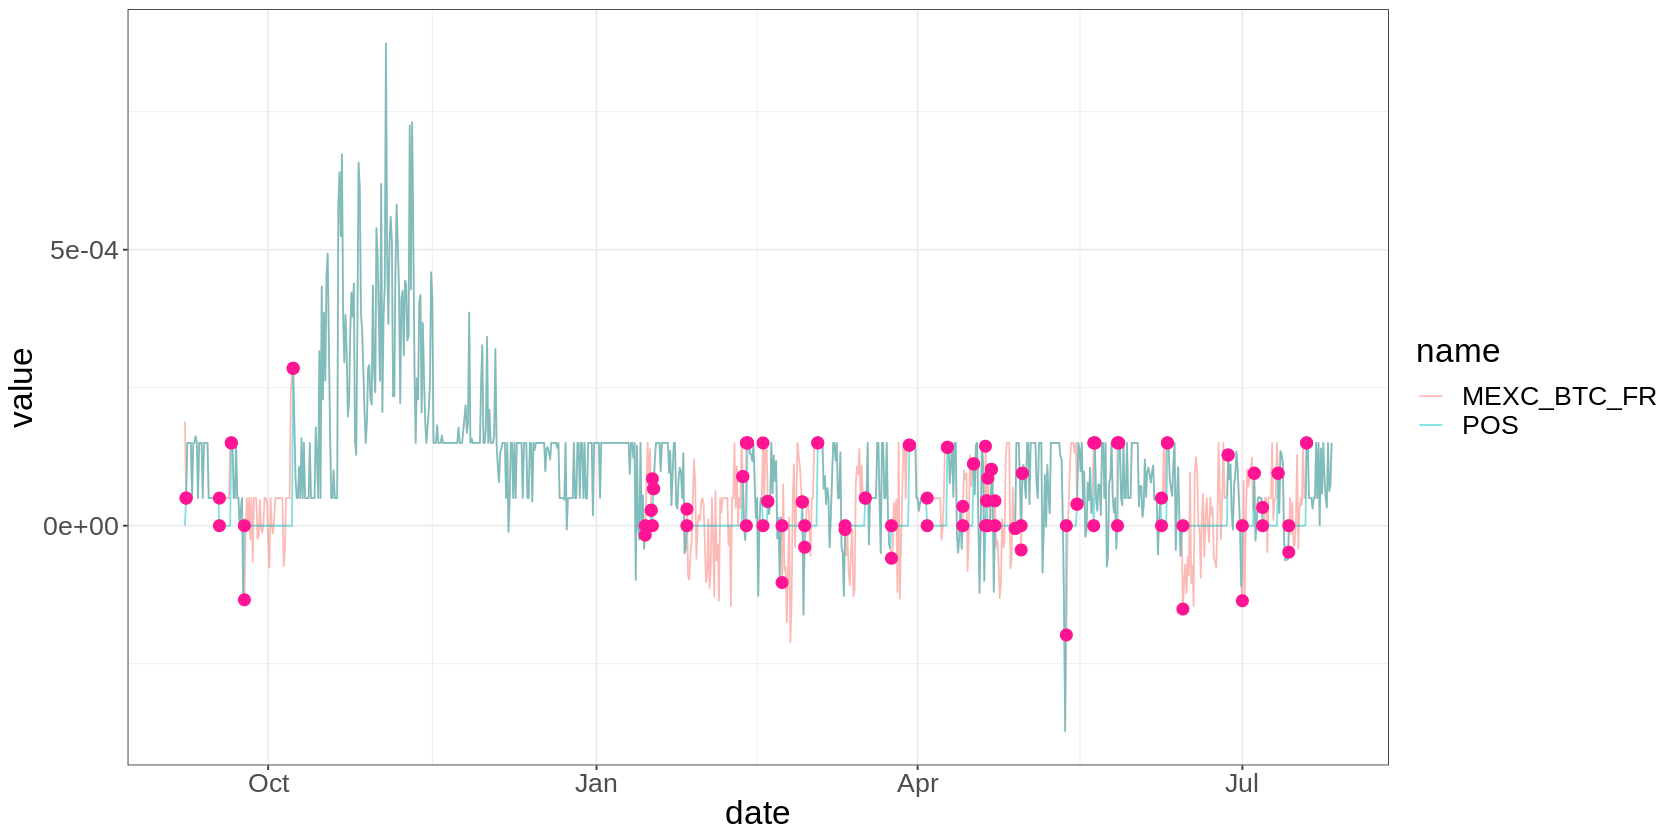

In [ ]:
# STRATEGY 2. use last 3 days as pred for next day

ftx_pred_cutoff <- 1e-04 / 2
window <- 3*3
pred_lag <- 1
FR_pivot %>%
  select(date, MEXC_BTC_FR, FTX_BTC_FR) %>%
  mutate(rolling3d_MEX_BTC_FR = roll_mean(FR_pivot$MEXC_BTC_FR, 
                                          width=window, 
                                          min_obs = 1)) %>%
  mutate(MEXC_PRED_3d = lag(rolling3d_MEX_BTC_FR, pred_lag) > ftx_pred_cutoff) %>%
  mutate(trade = MEXC_PRED_3d != lag(MEXC_PRED_3d)) %>%
  drop_na() %>%
  mutate(POS=case_when(MEXC_PRED_3d ~ MEXC_BTC_FR, TRUE~0)) %>%
  select(date, POS, MEXC_BTC_FR, trade) %>%
  pivot_longer(-c(date, trade)) %>%
  ggplot(aes(x=date, y=value, color=name)) + 
    geom_line(alpha=.5) +
    geom_point(data = . %>% filter(trade == TRUE), color = "deeppink", size = 3)


print_(glue("Number of trades: {
FR_pivot %>%
  select(date, MEXC_BTC_FR, FTX_BTC_FR) %>%
  mutate(rolling3d_MEX_BTC_FR = roll_mean(FR_pivot$MEXC_BTC_FR, 
                                          width=window, 
                                          min_obs = 1)) %>%
  mutate(MEXC_PRED_3d = lag(rolling3d_MEX_BTC_FR, pred_lag) > ftx_pred_cutoff) %>%
  mutate(trade = MEXC_PRED_3d != lag(MEXC_PRED_3d)) %>%
  filter(trade) %>% 
  .[[1]] %>%
  length()
  }"))

--------------------------------------------------------------------------
# E. Spot KLine


In [ ]:
# :::::::: MUST EXECUTE: MOVE TO LIB ::::::::

library(tidyverse)

mexc_spot_api <- function(mrkt_url, params=list()) {
  # print_(params)
  mexc_base_url <- 'https://api.mexc.com'
  url <- paste(mexc_base_url, mrkt_url, sep="")
  response <- httr::GET(url, query=params)
  res = httr::content(response,  as = "parsed")
  return (res)
}

mexc_spot_ping <- function() {
  mrkt_url <- '/api/v3/time'
  return(mexc_spot_api(mrkt_url) ) %>%
    as_tibble() %>%
    rename(date = data) %>%
    mutate(date = as_datetime(date/1000, tz="UTC"))
}

mexc_spot_ping()


$serverTime
[1] 1.659818e+12

In [ ]:
# :::::::: MUST EXECUTE: MOVE TO LIB ::::::::

#'-----------------------------------------------------------------------------
#' Helper function: Convert resolution in seconds to MEXC's standard strings
#' see MEXC's "Kline interval"
#' Purpose: map to RW functions arguments in seconds
mexc_map_resolution_spot <- function(res) {
  a <- str_split("1m、5m、15m、30m、60m、4h、1d、1m", "、")[[1]]
  names(a) <- c(60*1, 60*5, 60*15, 60*30, 60*60, 60*60*4, 60*60*24, 60*60*24*21)
  a
  return(a[as.character(res)][[1]])
}


#'-----------------------------------------------------------------------------
#' Helper function: Convert tables retreived from API call to tibble
table_to_tibble <- function(tab) {
  c0 <- c()
  t1 <- tab %>% transpose()
  for(k in 1:length(tab[[1]])) {
    c0 <- c(c0,
            t1[[k]] %>% 
            as.data.frame() %>% stack() %>% 
            select(values) %>% 
            type.convert(as.is=TRUE)    # automatic conversion https://stackoverflow.com/questions/7680959/convert-type-of-multiple-columns-of-a-dataframe-at-once
           ) 
  } 
  return(c0 %>% as.data.frame() %>% as_tibble())
}
# this didn't quite work but for ref
# https://www.geeksforgeeks.org/convert-list-of-lists-to-dataframe-in-r/
# convert list of list into df
# as.data.frame(do.call(rbind, tmp )) %>% as_tibble() %>% head()

#'-----------------------------------------------------------------------------
#' Get Single MEXC spot Market v0.1
#' 
#' @description Get spot market data for a single MEXC market.
#'
#' @param market name (string)
#' @param resolution representing aggregation length in seconds (int)
#' options available (top = this function param, bottom = passed to mexc API):
#'    60      300      900     1800     3600    14400   86400 1814400  
#'    "1m"   "5m"     "15m"   "30m"   "60m"     "4h"    "1d"  "1m"
#'
#' @param start_time human readable start time in UTC (string)
#' @param end_time human readable end time in UTC (string)
#'
#' @return dataframe of prices if API call was successful, otherwise call result
#' @export
#'
#' @examples
#' get_single_mexc_market("BTC_USDT", resolution = 86400, start_time = "2019-07-20", end_time = "2022-06-30)
get_single_mexc_spot_market <- function(sym="BTCUSDT", 
                                   resolution=86400, 
                                   start_time="2019-01-01", 
                                   end_time="") {
  interval <- resolution
  url <- '/api/v3/klines'
  start_time <- as.numeric(as.POSIXct(start_time, tz = "UTC")) * 1000
  if(end_time == "") {
    end_time <-  ""
  } else {
    end_time <- as.numeric(as.POSIXct(end_time, tz = "UTC")) * 1000
  }
  interval <- mexc_map_resolution_spot(interval)
  
  res_json <- mexc_spot_api(url, list(symbol=sym,
                                      interval=interval,
                                      startTime=start_time,
                                      endTime=end_time,
                                      limit=1000))
  # 0	Open time           - ignore
  # 1	Open
  # 2	High
  # 3	Low
  # 4	Close
  # 5	Volume              --> in units - ignore
  # 6	Close time                       := date
  # 7	Quote asset volume  --> in USDT [:= volume]
  res <- res_json %>%
    table_to_tibble() %>%
    rename(date_open=1, 
           open=2, high=3, low=4, close=5, 
           volume_asset=6, date=7, volume=8) %>%
    select(date, open, high, low, close, volume) %>%
    mutate(date = lubridate::as_datetime(date/1000)) %>%
    arrange(date) %>%  # API sends in chron, but ensuring


  return(res)
}

get_single_mexc_spot_market(
                                  start_time = "2018-12-31", 
                                  end_time = "2019-01-01"
) %>% tail()

date       open    high    low     close   volume  
1 2019-01-01 3801.09 3804.15 3649.99 3698.19 92972551

In [ ]:
# Sample raw data

d1 <- as.numeric(as.POSIXct("2020-11-12", tz = "UTC"))
d1

mexc_spot_api('/api/v3/klines', list(symbol="BTCUSDT",
                        interval='1d',
                        # startTime=d1*1000,
                        endTime=d1*1000,
                        limit=2)) %>% table_to_tibble()

[1] 1605139200

values       values.1 values.2 values.3 values.4 values.5  values.6    
1 1.659658e+12 22620.86 23465.90 22587.55 23311.00 10702.649 1.659744e+12
2 1.659744e+12 23311.00 23346.92 23110.03 23203.18  2715.336 1.659830e+12
  values.7 
1 247417435
2  63002874

In [ ]:
# :::::::: MUST EXECUTE: MOVE TO LIB ::::::::

#'-----------------------------------------------------------------------------
#' All MEXC Spot Symbols & last price

mexc_spot_syms <- function() {
  url <- '/api/v3/ticker/price'
  res <- mexc_spot_api(url) %>% 
    table_to_tibble() %>% 
    rename(ticker=1, last_price=2) 
  return(res)
}

#'-----------------------------------------------------------------------------
#' Get Multiple Spot Markets v0.1
#' 
#' @description Get market data for multiple markets.
#'
#' @param market name of the markets (vector of string)
#' @param resolution representing aggregation length in seconds (int)
#' @param start_time human readable start time in UTC (string)
#' @param end_time human readable end time in UTC (string)
#'
#' @return dataframe of prices if API call was successful, otherwise call result
#' @export
#'
#' @examples
#' get_multiple_mexc_spot_markets(c("BTCUSDT", "ETHUSDT"), resolution = 86400, start_time = "2019-07-20", end_time = "2022-06-30)
get_multiple_mexc_spot_markets <- function(markets, 
                                      resolution = 86400, 
                                      start_time = "2019-07-20", 
                                      end_time = "") {
  prices <- data.frame()
  for(market in markets) {
    cat_(glue("Fetching {market}...")) # print w/o line break
    these_prices <- get_single_mexc_spot_market(market, 
                                           resolution = resolution, 
                                           start_time = start_time, 
                                           end_time = end_time)
    if(!is.null(these_prices)) {
      print_(glue("Successful: {length(these_prices[[1]])} rows."))
      these_prices <- these_prices %>% 
        dplyr::mutate(ticker = market)
      
      prices <- dplyr::bind_rows(prices, these_prices)
    } else {
      print_(glue("Failed."))
    }
  }
    
    prices
}

In [ ]:
tmp <- get_multiple_mexc_spot_markets(c("BTCUSDT", "ETHUSDT"), resolution = 86400, start_time = "2019-07-20")
tmp %>% head(3)
tmp %>% tail(3)

Fetching BTCUSDT...Successful: 1000 rows.
Fetching ETHUSDT...Successful: 1000 rows.


date       open    high    low     close   volume    ticker 
1 2019-11-12 9035.39 9070.69 8623.05 8733.84 473005540 BTCUSDT
2 2019-11-13 8733.84 8880.42 8583.88 8815.94 452176833 BTCUSDT
3 2019-11-14 8815.94 8836.56 8714.33 8775.88 301566568 BTCUSDT

date       open    high    low     close   volume    ticker 
1998 2022-08-05 1618.38 1662.98 1581.06 1607.80 109599016 ETHUSDT
1999 2022-08-06 1607.80 1741.88 1605.62 1737.02 280589569 ETHUSDT
2000 2022-08-07 1737.02 1749.49 1686.28 1708.34  78895731 ETHUSDT

--------------------------------------------------------------------------
# F. Turn insights from D. into code to predict >0 perp across assets

- Retrieve all data
1. Retrieve Spot KLine
2. Rettrieve Perp KLine
3. Retrieve Perp FR
4. Retrieve FTX Perp FR (predictor)
- Compute PnL
5. Compute Equity line of (Short Perp - Long Spot) [not going to be 0!]
6. Add Fr
7. Factor short cost [note: dirty hedge TBD where not shorting for all coins & taking both side of the perp]

GOAL: run across all perps to identify a tradeable universe

In [ ]:

# NEED: Symbol conversion table between exchanges and spot/perp

# Asset
asset_list <- c("BTC", "ETH", "SOL", "MATIC")

# Analysis start date
start_date = "2021-01-01"


In [ ]:
# :::::::: MUST EXECUTE: MOVE TO LIB ::::::::

# Pre-load data in global environment
preload_RW <- function() {
  rwlab_data_auth()
  ftx_perp_rate <<- rwRtools::crypto_get_perp_rates()
  ftx_futures <<- rwRtools::crypto_get_futures()
}

preload_RW()

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/auth?client_id=603366585132-0l5tra7gl2i20iftqangp7iskte4f3s0.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code



Enter authorization code: 4/1AdQt8qi1tt9zZ8rrG31H5YDW4662Lx-KIChFguBAsmIsWpRvCwikoJkbvGU


ℹ Downloading ftx_perpetual_funding_rates.feather

✔ Saved ftx_perpetual_funding_rates.feather to ftx/ftx_perpetual_funding_rates.…





File successfully transferred


ℹ Downloading ftx_futures_ohlc_1h.feather

✔ Saved ftx_futures_ohlc_1h.feather to ftx/ftx_futures_ohlc_1h.feather  ( 196.1…





File successfully transferred


In [ ]:
# :::::::: MUST EXECUTE: MOVE TO LIB ::::::::

# helper functions to go from asset -> symbol
FTX_perp_sym <- function(asset) paste0(asset, "-PERP")
MEXC_perp_sym <- function(asset) paste0(asset, "_USDT")

#'-----------------------------------------------------------------------------
#' Get FR for a Single Markets v0.1
#' 
#' @description Get FR data for a market.
fetch_FR <- function(asset="BTC") {
  # ftx_perp_rate MUST be pre-loaded from RW -> use preload_RW()

  # FTX FR data
  FTX_rate <- ftx_perp_rate %>% 
    filter(ticker == FTX_perp_sym(asset)) %>%
    mutate(date = lubridate::as_datetime(date))

  FTX_rate_8h <- FTX_rate %>%
    group_by(.D1 = date(date-60*60),  # remove 1h from the timestamp so as to include 00:00 to the previous day
            .H8 = as.integer(hour(date-60*60)/8)) %>%
    summarize(ticker = last(ticker), 
              date = last(na.omit(date)), 
              rate = sum(rate), 
              .groups = 'drop') %>%   # to eliminate error message (?)
    arrange(ticker, date) %>%         # to ensure groupby doesnt re-order differently (should not give D1 before H8)
    ungroup() %>%
    select(-.H8, -.D1) %>%
    mutate(exchange="FTX", asset=asset)

  # MEXC FR data
  MEXC_rate <- get_single_mexc_funding_rate(MEXC_perp_sym(asset)) %>%
    mutate(exchange="MEXC", asset=asset)

  min_date <- min(MEXC_rate$date)

  # All FR data (mapped to 8h)
  FR <- MEXC_rate %>%
    merge(FTX_rate_8h, all=TRUE) %>% # FTX payments every hour vs. every 8h for MEXC
    filter(date>=as.Date(min_date))

  return(FR)
}


# :::::::: MUST EXECUTE: MOVE TO LIB ::::::::

#'-----------------------------------------------------------------------------
#' Get FR for Multiple Markets v0.1
#' 
#' @description Get FR data for multiple markets.
#'
#' @param market name of the markets (vector of string)
#'
#' @return dataframe of prices if API call was successful, otherwise call result
#' @export
#'
#' @examples
#' get_multiple_mexc_spot_markets(c("BTCUSDT", "ETHUSDT"), resolution = 86400, start_time = "2019-07-20", end_time = "2022-06-30)
fetch_multiple_FR <- function(markets) {
  prices <- data.frame()
  for(market in markets) {
    cat_(glue("Fetching {market}...")) # print w/o line break
    these_prices <- fetch_FR(market)
    if(!is.null(these_prices)) {
      print_(glue("Successful: {length(these_prices[[1]])} rows."))
      these_prices <- these_prices #%>% 
        # dplyr::mutate(ticker = market)
      prices <- dplyr::bind_rows(prices, these_prices)
    } else {
      print_(glue("Failed."))
    }
  }
    
    prices
}


In [ ]:
FR_tmp <- fetch_FR("SOL")

ticker   rate      date                exchange asset
1 SOL_USDT -0.001426 2022-05-12 08:00:00 MEXC     SOL  
2 SOL_USDT -0.001281 2022-05-11 16:00:00 MEXC     SOL

ticker   rate     date                exchange asset
1967 SOL-PERP 0.000496 2021-09-07 16:00:00 FTX      SOL  
1968 SOL-PERP 0.000496 2021-10-23 00:00:00 FTX      SOL

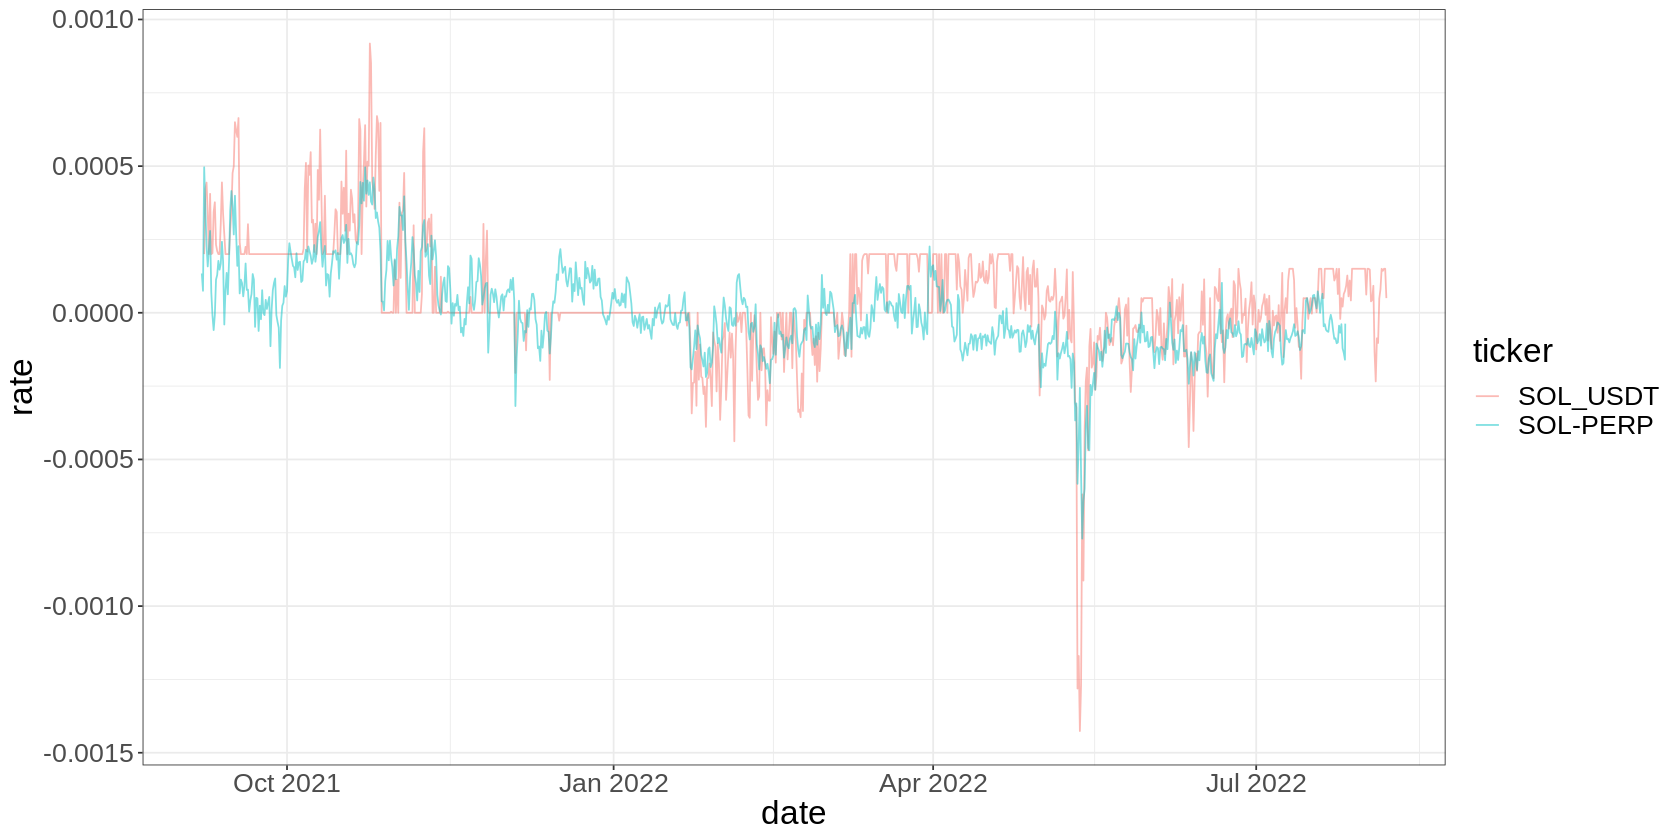

In [ ]:
FR_tmp %>% head(2)
FR_tmp %>% tail(2)
FR_tmp %>%
  ggplot(aes(color=ticker, x=date, y=rate)) + 
  geom_line(alpha=.5)#, labels = c("BTC Perp FR MEXC", "BTC Perp FR FTX (10x for scale)"))

In [ ]:
# FR_tmp2 <- bind_rows(FR_tmp,  fetch_FR("BTC"), fetch_FR("MATIC"))

FR_tmp2 <- fetch_multiple_FR(c("SOL", "BTC", "MATIC"))

Fetching SOL...

Successful: 1965 rows.

Fetching BTC...

Successful: 1965 rows.

Fetching MATIC...

Successful: 1965 rows.

In [ ]:
# params: FR = Funding Rate tibble
mexc_hlines <- function(.FR) .FR %>% 
  filter(exchange == "MEXC") %>%        # this only applies to MEXC (exchange-specific)
  group_by(ticker, asset) %>%
  count(rate) %>% top_n(2) %>%
  mutate(rate_rank=rank(-rate)) %>%
  arrange(desc(rate), .by_group = TRUE) %>%
  ungroup()

# params: .hlines = mexc_hlines(FR) -> so that this value can be calculated once for an entire table
FR_side <- function(.asset, .rate, .hlines) {
  h <- .hlines %>% filter(asset==.asset & rate_rank==1) %>%  select(rate) %>% .[[1]]
  l <- .hlines %>% filter(asset==.asset & rate_rank==2) %>%  select(rate) %>% .[[1]]
  r <- case_when( .rate < l ~ 1,
                  .rate <= h ~ 2,
                  TRUE ~ 3
                )
  return(r)
}


In [ ]:
mexc_hlines(FR_tmp2)

print_("")
print_("side:")
FR_side("BTC", 0.00005, mexc_hlines(FR_tmp2))

Selecting by n


ticker     asset rate    n   rate_rank
1 BTC_USDT   BTC   0.00015 264 1        
2 BTC_USDT   BTC   0.00005 193 2        
3 MATIC_USDT MATIC 0.00020  62 1        
4 MATIC_USDT MATIC 0.00000 385 2        
5 SOL_USDT   SOL   0.00020 157 1        
6 SOL_USDT   SOL   0.00000 279 2

[1] ""
[1] "side:"


Selecting by n


[1] 2

In [ ]:
mexc_hlines_rate <- function(.FR, .asset="BTC", .rank=1) 
  mexc_hlines(.FR) %>% filter(asset==.asset & rate_rank==.rank) %>% .$rate

mexc_hlines_rate(FR_tmp2, "BTC", .rank=1)

Selecting by n


[1] 0.00015

Selecting by n


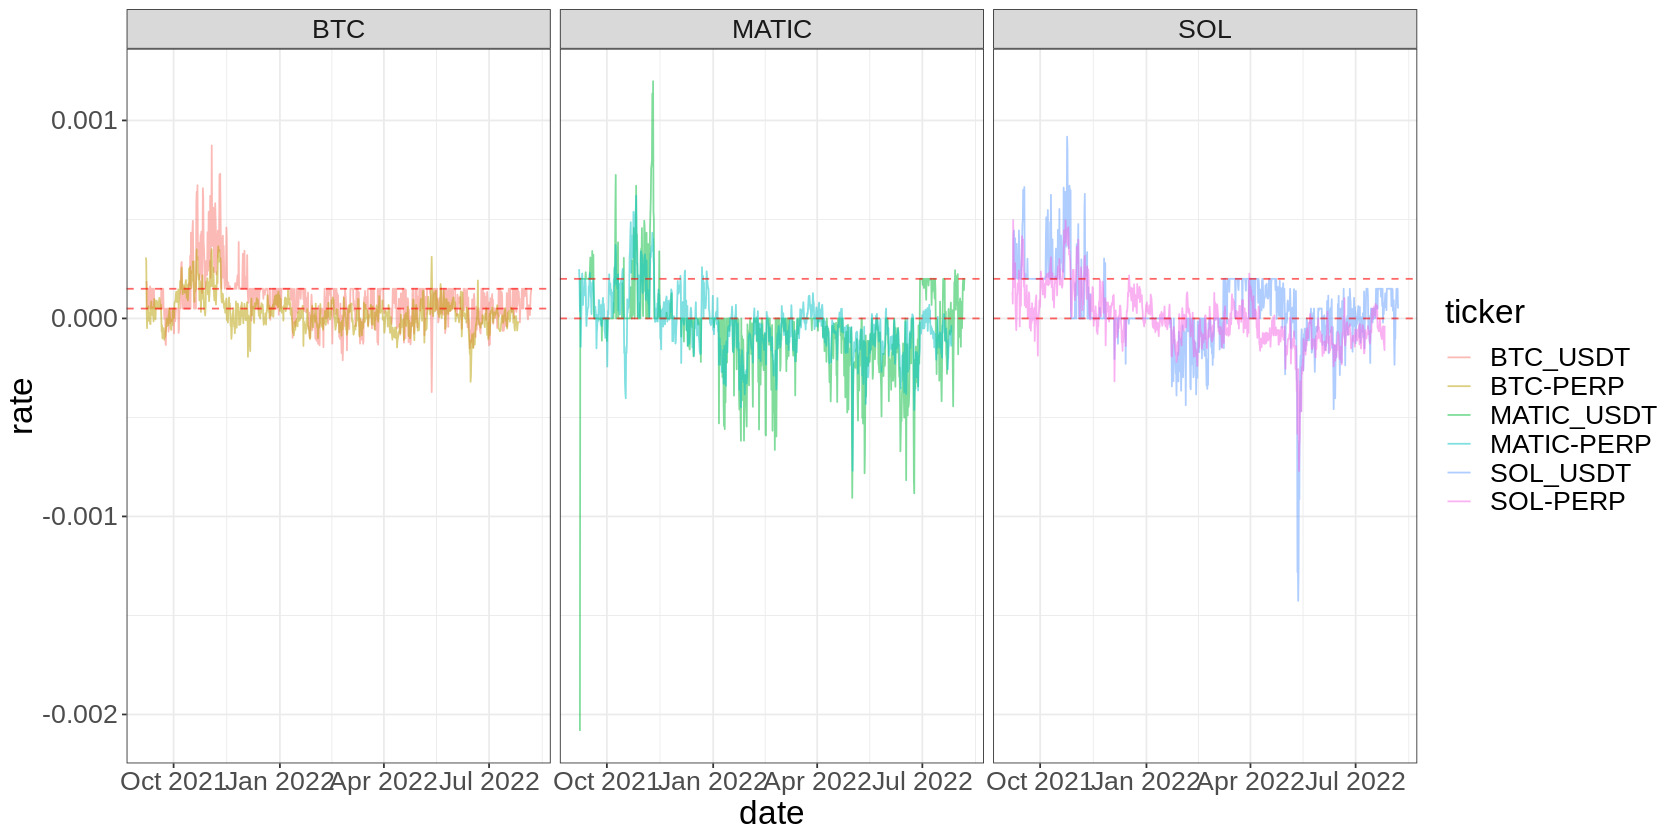

In [ ]:
FR_tmp2 %>%
  ggplot(aes(color=ticker, x=date, y=rate)) + 
    facet_grid(cols = vars(asset)) +
      geom_line(alpha=.5) +
      geom_hline(data=mexc_hlines(FR_tmp2), aes(yintercept=rate), 
                 linetype="dashed", color = "red", alpha=0.6) # this maps the mexc_hlines tibble since has the same col names resulting in 2 rows
      
      # longer code that does the same:
      # geom_hline(data=mexc_hlines(FR_tmp2) %>% filter(rate_rank==1), aes(yintercept=rate), 
      #            linetype="dashed", color = "red", alpha=0.6) +
      # geom_hline(data=mexc_hlines(FR_tmp2) %>% filter(rate_rank==2), aes(yintercept=rate), 
      #            linetype="dashed", color = "red", alpha=0.6)



In [ ]:
FR_tmp2 %>% head()
 
mexc_hlines(FR_tmp2) #%>%
  # select(-ticker, -n) %>%
  # pivot_wider(names_from = rate_rank, values_from = rate)

ticker   rate      date                exchange asset
1 SOL_USDT -0.001426 2022-05-12 08:00:00 MEXC     SOL  
2 SOL_USDT -0.001281 2022-05-11 16:00:00 MEXC     SOL  
3 SOL_USDT -0.001270 2022-05-12 16:00:00 MEXC     SOL  
4 SOL_USDT -0.001170 2022-05-12 00:00:00 MEXC     SOL  
5 SOL_USDT -0.000913 2022-05-13 08:00:00 MEXC     SOL  
6 SOL_USDT -0.000619 2022-05-13 00:00:00 MEXC     SOL

Selecting by n


ticker     asset rate    n   rate_rank
1 BTC_USDT   BTC   0.00015 264 1        
2 BTC_USDT   BTC   0.00005 193 2        
3 MATIC_USDT MATIC 0.00020  62 1        
4 MATIC_USDT MATIC 0.00000 385 2        
5 SOL_USDT   SOL   0.00020 157 1        
6 SOL_USDT   SOL   0.00000 279 2

In [ ]:
FR_pred <- function(.FR, .window = 3) {
  # f <- function(.a,.b,.c) return(.b)
  hlines <- mexc_hlines(.FR) %>% 
              select(asset, rate, rate_rank) %>%
              pivot_wider(names_from = rate_rank, names_prefix = "rate",values_from = rate)
              # columns: rate1 = high hline / rate2 = low hline
  res <- .FR %>% 
    arrange(ticker, date) %>%
    merge(hlines, all=TRUE) %>%
    mutate(side=case_when(rate<rate2 ~ 2,
                          rate<=rate1 ~ 0,
                          TRUE ~ 3)) %>%
    select(-rate1, -rate2) %>%
    group_by(ticker) %>%
    mutate("rate_rolling{.window}d":=roll_mean(rate, .window)) 

  return(res)
}

FR_pred(FR_tmp2) %>% head()


Selecting by n


asset ticker   rate       date                exchange side rate_rolling3d
1 BTC   BTC_USDT 0.00018864 2021-09-07 16:00:00 MEXC     3              NA  
2 BTC   BTC_USDT 0.00005000 2021-09-08 00:00:00 MEXC     0              NA  
3 BTC   BTC_USDT 0.00015000 2021-09-08 08:00:00 MEXC     0    0.0001295467  
4 BTC   BTC_USDT 0.00015000 2021-09-08 16:00:00 MEXC     0    0.0001166667  
5 BTC   BTC_USDT 0.00015000 2021-09-09 00:00:00 MEXC     0    0.0001500000  
6 BTC   BTC_USDT 0.00015000 2021-09-09 08:00:00 MEXC     0    0.0001500000

Selecting by n
Warning message:
“Removed 9 rows containing non-finite values (stat_density).”


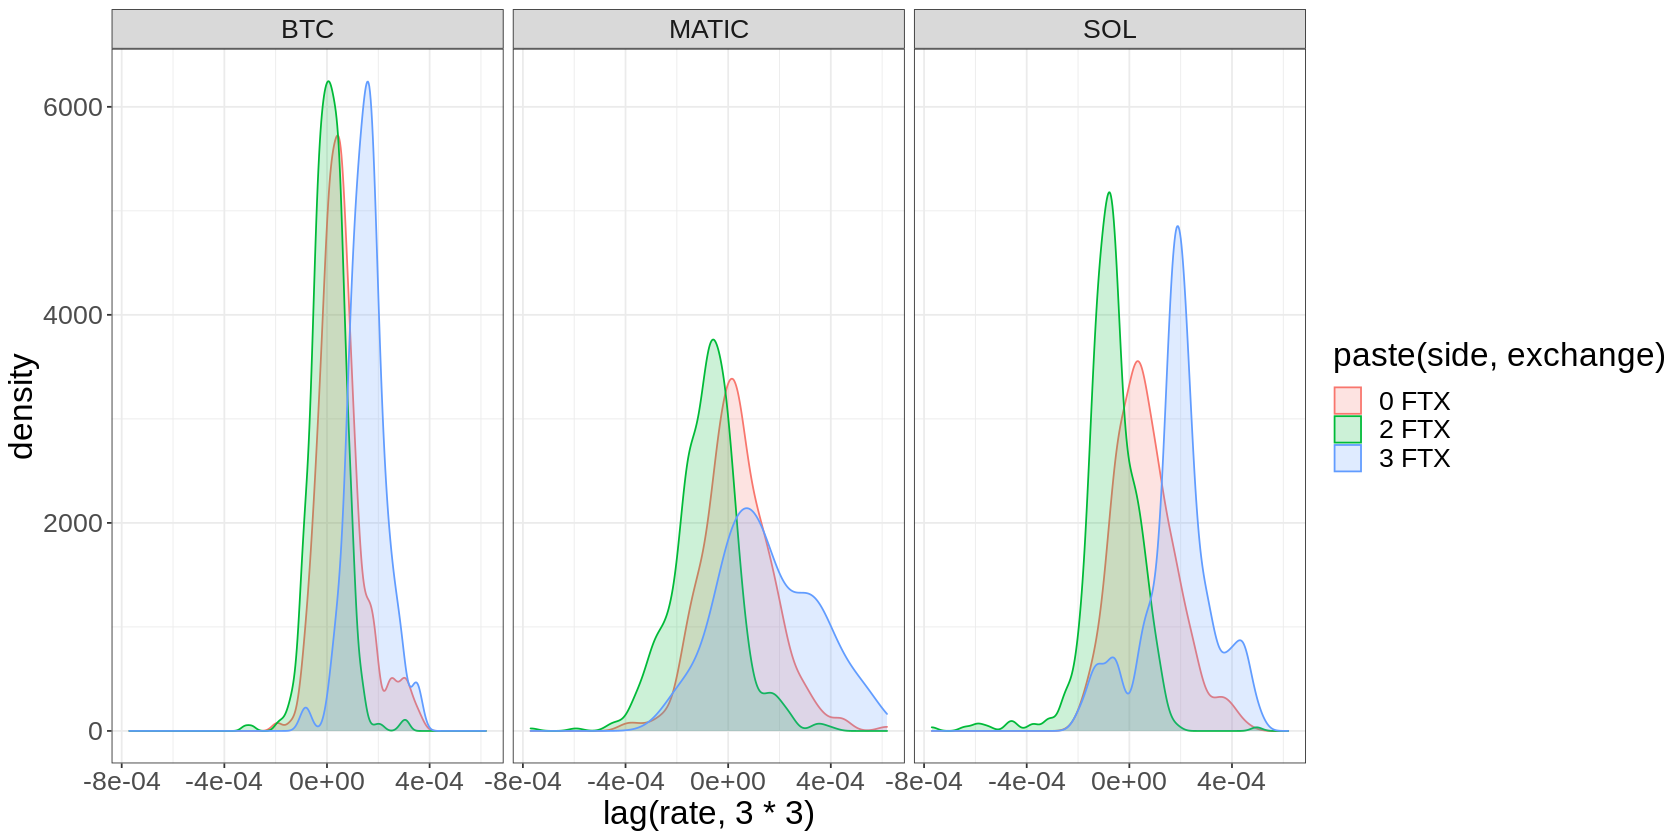

In [ ]:
FR_pred(FR_tmp2) %>% 
  filter( exchange=="FTX") %>%
  ggplot(aes(x=lag(rate,3*3), 
             color=paste(side, exchange), 
             fill=paste(side, exchange))) +
    # geom_histogram()+
    facet_grid(cols = vars(asset)) +
      geom_density(alpha=.2) 
      # +
      # labs(title=glue("lagging feature vs. predicted value of high(2) / med(0) / low(1) MEXC FR \nwindow ={window} days"))


In [ ]:
FR_side(list("BTC", .1, mexc_hlines(FR_tmp2)))

ERROR: ignored

In [ ]:

plot_FR_pred <- function(show_mexc=TRUE, window=7) {
  FR_pivot %>% select(date, FTX_BTC_FR, MEXC_BTC_FR) %>%
    mutate("rolling{window}d_FTX_BTC_FR" := roll_mean(FR_pivot$FTX_BTC_FR, width=3*window, min_obs = min(window, 10))) %>%
    mutate("rolling{window}d_MEX_BTC_FR" := roll_mean(FR_pivot$MEXC_BTC_FR, width=3*window, min_obs = min(window, 10))) %>%
    # # Only keep those we want to analyze
    select(date, case_when(show_mexc ~ 3, TRUE ~ 4)) %>%
    pivot_longer(-date, names_to="exch", values_to="rate")  %>%
    merge(FR_pivot_sides, all=TRUE)  %>% #select(side) %>% table() %>% as_tibble()
    mutate(side = paste(side)) %>%
    ggplot(aes(x=lag(rate,3*window), color=paste(side, exch), fill=paste(side, exch))) +
      # geom_histogram()+
      geom_density(alpha=.2) + 
      geom_vline(xintercept = mexc_hlines[[1,1]], linetype="dotted", 
                color = "blue", size=0.5) + 
      geom_vline(xintercept = mexc_hlines[[2,1]], linetype="dotted", 
                color = "blue", size=0.5) +
      labs(title=glue("lagging feature vs. predicted value of high(2) / med(0) / low(1) MEXC FR \nwindow ={window} days"))
}

window <- 1
plot_FR_pred(show_mexc=FALSE, window=window)
plot_FR_pred(show_mexc=TRUE, window=window)

window <- 4
plot_FR_pred(show_mexc=FALSE, window=window)
plot_FR_pred(show_mexc=TRUE, window=window)

window <- 15
plot_FR_pred(show_mexc=FALSE, window=window)
plot_FR_pred(show_mexc=TRUE, window=window)


In [ ]:
# STRATEGY 1. use FTX last 3-6 days as pred for next day
strat1 <- function() {
  ftx_pred_cutoff <- 1e-04 
  window <- 3*6
  pred_lag <- 1
  FR_pivot %>%
    select(date, MEXC_BTC_FR, FTX_BTC_FR) %>%
    mutate(rollingNd_FTX_BTC_FR = roll_mean(FR_pivot$FTX_BTC_FR, 
                                            width=window, 
                                            min_obs = 1)) %>%
    mutate(MEXC_PRED_3d = lag(rollingNd_FTX_BTC_FR, pred_lag) > ftx_pred_cutoff) %>%
    mutate(trade = MEXC_PRED_3d != lag(MEXC_PRED_3d)) %>%
    drop_na() %>%
    mutate(POS=case_when(MEXC_PRED_3d ~ MEXC_BTC_FR, TRUE~0)) %>%
    select(date, POS, MEXC_BTC_FR, trade) %>%
    pivot_longer(-c(date, trade)) %>%
    ggplot(aes(x=date, y=value, color=name)) + 
      geom_line(alpha=.5) +
      geom_point(data = . %>% filter(trade == TRUE), color = "deeppink", size = 3)

  print_(glue("Number of trades: {
  FR_pivot %>%
    select(date, MEXC_BTC_FR, FTX_BTC_FR) %>%
    mutate(rollingNd_FTX_BTC_FR = roll_mean(FR_pivot$FTX_BTC_FR, 
                                            width=window, 
                                            min_obs = 1)) %>%
    mutate(MEXC_PRED_3d = lag(rollingNd_FTX_BTC_FR, pred_lag) > ftx_pred_cutoff) %>%
    mutate(trade = MEXC_PRED_3d != lag(MEXC_PRED_3d)) %>%
    filter(trade) %>%
    .[[1]] %>%
    length()  
    }"))
}

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

ERROR: ignored

In [ ]:
mexc_spot_syms <- function() {
  url <- '/api/v3/ticker/price'
  res <- mexc_spot_api(url) %>% 
    table_to_tibble() %>% 
    rename(ticker=1, last_price=2) 
  return(res)
}

In [ ]:
sym_tmp <-  mexc_spot_syms()

In [ ]:
# :::::::: MUST EXECUTE: MOVE TO LIB ::::::::

mexc_futures_syms <- function() {
  mrkt_url <- 'api/v1/contract/ticker'
  mexc_api(mrkt_url) %>%
    .$data %>%
    # transpose() %>% .[1:17] %>% transpose() %>%
    map_df(unlist) %>%  # needed since there is a nested list
    as_tibble() %>%
    # unlist does not convert automatically (keeps all chr)
    type.convert(as.is=TRUE) %>%   # automatic conversion https://stackoverflow.com/questions/7680959/convert-type-of-multiple-columns-of-a-dataframe-at-once
    mutate(date=as_datetime(timestamp/1000)) %>%
    # add asset & currency (denominated in crypto if USD, otherwise in specified currency)
    rowwise() %>%
    mutate(asset=str_split(symbol, "_", simplify = TRUE)[1]) %>%
    mutate(currency=str_split(symbol, "_", simplify = TRUE)[2]) %>%
    mutate(currency=case_when(currency=="USD" ~ asset, TRUE ~ currency)) %>%
    ungroup()
}


mexc_futures_syms2 <- function() {
  mrkt_url <- 'api/v1/contract/risk_reverse'
  mexc_api(mrkt_url) %>%
    .$data %>%
    map_df(as.data.frame) %>%
    as_tibble()%>%
    mutate(date=as_datetime(timestamp/1000)) %>%
    rowwise() %>%
    mutate(asset=str_split(symbol, "_", simplify = TRUE)[1]) %>%
    ungroup()
}


In [ ]:
# note: USD -> crypto denominated / USDT -> USDT denomination

mexc_futures_syms() %>% filter(symbol %in% c("BTC_USD", "ETH_USD", "ETH_USDT") )

mexc_futures_syms2() %>% filter(symbol %in% c("BTC_USD", "ETH_USD", "ETH_USDT") )

symbol   lastPrice bid1     ask1     volume24 amount24     holdVol 
1 BTC_USD  23151.90  23145.70 23151.80  3338183     14469.73    37346
2 ETH_USDT  1706.03   1706.02  1706.03 44660714 758284229.45 57331365
3 ETH_USD   1706.78   1706.67  1706.68 31119056    183166.77   206794
  lower24Price high24Price riseFallRate ⋯ fundingRate maxBidPrice minAskPrice
1 22843.20     23249.70    -0.0021      ⋯ 0.000214    25472.40    20841.10   
2  1667.14      1723.61    -0.0053      ⋯ 0.000029     1877.77     1536.36   
3  1667.73      1723.00    -0.0049      ⋯ 0.000177     1878.23     1536.74   
  timestamp    riseFallRatesOfTimezone1 riseFallRatesOfTimezone2
1 1.659879e+12 -0.0007                  0.0090                  
2 1.659879e+12 -0.0033                  0.0095                  
3 1.659879e+12 -0.0026                  0.0098                  
  riseFallRatesOfTimezone3 date                asset currency
1 -0.0021                  2022-08-07 13:28:28 BTC   BTC     
2 -0.0053                  2022-08-07 13:28:28 ETH   USDT    
3 -0.0049                  2022-08-07 13:28:28 ETH   ETH

symbol   currency available    timestamp    date                asset
1 ETH_USDT USDT     3.669816e+06 1.659879e+12 2022-08-07 13:28:28 ETH  
2 BTC_USD  BTC      6.676545e+00 1.659879e+12 2022-08-07 13:28:28 BTC  
3 ETH_USD  ETH      1.967994e+02 1.659879e+12 2022-08-07 13:28:28 ETH

In [ ]:
x <- mexc_futures_syms2_raw() %>% .[1:3]

In [ ]:
x %>% map_df(unlist) %>% as_tibble() %>%

            type.convert(as.is=TRUE)    # automatic conversion https://stackoverflow.com/questions/7680959/convert-type-of-multiple-columns-of-a-dataframe-at-once
    # mutate(date=as_datetime(timestamp/1000))

symbol   lastPrice bid1     ask1     volume24 amount24  holdVol  
1 GMT_USDT 0.927370  0.927050 0.927210   418615 3881368.7     35574
2 FLM_USDT 0.215600  0.215900 0.216000 12312030 2720047.1  23308966
3 RSR_USDT 0.007115  0.007113 0.007116 86884139  617835.3 121092670
  lower24Price high24Price riseFallRate riseFallValue indexPrice fairPrice
1 0.908830     0.940660    -0.0096      -0.009030     0.928330   0.927740 
2 0.211800     0.243700    -0.0891      -0.021100     0.216000   0.216000 
3 0.006963     0.007268    -0.0135      -0.000098     0.007118   0.007112 
  fundingRate maxBidPrice minAskPrice timestamp    riseFallRatesOfTimezone1
1 -3.6e-05    1.113990    0.742660    1.659877e+12 -0.0095                 
2  2.0e-04    0.302400    0.129600    1.659877e+12 -0.0730                 
3 -7.6e-05    0.008541    0.005694    1.659877e+12 -0.0113                 
  riseFallRatesOfTimezone2 riseFallRatesOfTimezone3
1  0.0035                  -0.0096                 
2 -0.0722                  -0.0891                 
3 -0.0019                  -0.0135

In [ ]:
unlist( x ) %>% as.data.frame

.            
symbol                   GMT_USDT     
lastPrice                0.92461      
bid1                     0.92456      
ask1                     0.92467      
volume24                 426954       
amount24                 3960090.0687 
holdVol                  37407        
lower24Price             0.90883      
high24Price              0.94066      
riseFallRate             -0.0125      
riseFallValue            -0.01179     
indexPrice               0.92529      
fairPrice                0.92487      
fundingRate              -3.6e-05     
maxBidPrice              1.11034      
minAskPrice              0.74023      
timestamp                1659876297030
riseFallRatesOfTimezone1 -0.0132      
riseFallRatesOfTimezone2 6e-04        
riseFallRatesOfTimezone3 -0.0125

In [ ]:
strsplit("ab_c", "_")[[1]][[1]]

[1] "ab"

In [ ]:
mexc_futures_syms2() %>% 
  filter(currency == "USDT") %>%
  arrange(desc(available))
 

symbol        currency available timestamp   
1   ETH_USDT      USDT     3668329.2 1.659875e+12
2   BTC_USDT      USDT     3413613.6 1.659875e+12
3   SHIB_USDT     USDT      674619.6 1.659875e+12
4   DOGE_USDT     USDT      415225.3 1.659875e+12
5   ETC_USDT      USDT      402777.2 1.659875e+12
6   SOL_USDT      USDT      353689.5 1.659875e+12
7   GALA_USDT     USDT      270101.0 1.659875e+12
8   DOT_USDT      USDT      266452.7 1.659875e+12
9   RACA_USDT     USDT      266311.1 1.659875e+12
10  APE_USDT      USDT      265651.1 1.659875e+12
11  WAVES_USDT    USDT      264200.3 1.659875e+12
12  LTC_USDT      USDT      261941.0 1.659875e+12
13  MATIC_USDT    USDT      252153.4 1.659875e+12
14  EOS_USDT      USDT      249140.8 1.659875e+12
15  FITFI_USDT    USDT      202050.6 1.659875e+12
16  XRP_USDT      USDT      201683.1 1.659875e+12
17  OP_USDT       USDT      196730.3 1.659875e+12
18  ATOM_USDT     USDT      195053.7 1.659875e+12
19  PEOPLE_USDT   USDT      186559.5 1.659875e+12
20  ICP_USDT      USDT      185817.7 1.659875e+12
21  LINK_USDT     USDT      183205.4 1.659875e+12
22  FLM_USDT      USDT      180408.5 1.659875e+12
23  ADA_USDT      USDT      177369.8 1.659875e+12
24  AXS_USDT      USDT      176916.6 1.659875e+12
25  LUNANEW_USDT  USDT      170389.2 1.659875e+12
26  HT_USDT       USDT      160671.4 1.659875e+12
27  LUNC_USDT     USDT      149571.4 1.659875e+12
28  USTC_USDT     USDT      147117.9 1.659875e+12
29  OKB_USDT      USDT      144932.2 1.659875e+12
30  LOOKS_USDT    USDT      141878.8 1.659875e+12
⋮   ⋮             ⋮        ⋮         ⋮           
90  AVAX_USDT     USDT     90509.114 1.659875e+12
91  BABYDOGE_USDT USDT     89954.806 1.659875e+12
92  SRM_USDT      USDT     89630.994 1.659875e+12
93  AAVE_USDT     USDT     87934.515 1.659875e+12
94  BAT_USDT      USDT     86618.065 1.659875e+12
95  YGG_USDT      USDT     86387.715 1.659875e+12
96  SAND_USDT     USDT     85489.993 1.659875e+12
97  PIT_USDT      USDT     84879.419 1.659875e+12
98  UNFI_USDT     USDT     84851.209 1.659875e+12
99  MANA_USDT     USDT     83538.471 1.659875e+12
100 MKR_USDT      USDT     82718.235 1.659875e+12
101 OGN_USDT      USDT     82341.865 1.659875e+12
102 ALICE_USDT    USDT     81304.797 1.659875e+12
103 COTI_USDT     USDT     81293.534 1.659875e+12
104 ZIL_USDT      USDT     81045.812 1.659875e+12
105 HOT_USDT      USDT     79132.405 1.659875e+12
106 EGLD_USDT     USDT     71051.651 1.659875e+12
107 LINA_USDT     USDT     71014.164 1.659875e+12
108 TRX_USDT      USDT     69671.756 1.659875e+12
109 FTM_USDT      USDT     62324.176 1.659875e+12
110 IMX_USDT      USDT     59114.168 1.659875e+12
111 AKRO_USDT     USDT     57744.507 1.659875e+12
112 HNT_USDT      USDT     54821.378 1.659875e+12
113 DYDX_USDT     USDT     51138.222 1.659875e+12
114 OCEAN_USDT    USDT     50280.341 1.659875e+12
115 CHZ_USDT      USDT     40672.832 1.659875e+12
116 YFII_USDT     USDT      7355.688 1.659875e+12
117 GST_USDT      USDT      5937.620 1.659875e+12
118 RSR_USDT      USDT      5221.508 1.659875e+12
119 ANC_USDT      USDT      4242.322 1.659875e+12

In [ ]:
sym_tmp$data %>%
      # purrr::transpose() %>%
      map_df(as.data.frame) %>%
      select(symbol)
      # %>%
      # as_tibble() #%>% transpose() #%>%
      # dplyr::rename(volume = vol) %>%
      # dplyr::mutate(date = lubridate::as_datetime(time)) %>%
      # dplyr::select(-time, -amount, -realOpen, 
      #               -realHigh, -realLow, -realClose) %>%
      # arrange(date) # it appears already comes sorted, but to ensure.
    

ERROR: ignored